# 0.0. Imports

In [1]:
cd ~/repos/health_insurance/

/home/mars/repos/health_insurance


In [2]:
# Credentials & Project (Library made for this project)
from src import credentials
from src import project

# SQL Library for python
from sqlalchemy              import create_engine

# Pandas, Numpy & Others libraries
import pandas                as pd
import numpy                 as np

# Libraries for EDA & graph plots
import seaborn               as sns
from pandas_profiling        import ProfileReport
from matplotlib              import pyplot as plt
from matplotlib.artist       import Artist 
from tabulate                import tabulate
import scikitplot            as skplt

# Feature Selection
from boruta                  import BorutaPy

# Preprocessing and split data
from sklearn                 import preprocessing as pp
from sklearn                 import model_selection as ms
from sklearn.model_selection import StratifiedKFold

import pickle

# Models

from sklearn                 import ensemble     as en
from sklearn                 import linear_model as lm

from lightgbm                import LGBMClassifier

## 0.1. Helper Functions

In [3]:
# The functions of this project are in the project.py(class)
insurance_functions = project.ProjectFunctions()

## 0.2. Collect data with SQL

### 0.2.1. Credentials

In [4]:
database_connection = credentials.Credentials().database_connection()


### 0.2.2. Postgresql connection and load data

In [5]:
db = create_engine(database_connection)
conn = db.connect()

In [6]:
query = """
    SELECT *
    FROM pa004.users u INNER JOIN pa004.vehicle v   ON (u.id = v.id)
                       INNER JOIN pa004.insurance i ON (u.id = i.id)
                 """

In [7]:
df = pd.read_sql_query( query, con=conn )

In [8]:
conn.close()

In [9]:
df.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [10]:
df_raw = df.loc[:,~df.columns.duplicated()].copy()

In [11]:
df_raw.to_csv( 'data/raw/health_insurance.csv', index=False )

## 0.3. Business Search

Top Features: Age, Years from driver license, Garage, Security alarm,Historical Car's Damages, accidents and theft, Gender, Civil State, Car Model, City Risk
Sources: 

https://blog.rodobens.com.br/perfil-no-seguro-auto

Cross Selling Strategy

Analyse products interesting to a customer

Dont try cross sell products more expensive then main

Sources:

https://resultadosdigitais.com.br/blog/cross-selling-up-selling/#:~:text=O%20cross%20selling%2C%20tamb%C3%A9m%20chamado,oferta%20que%20o%20cliente%20adquiriu.

https://neilpatel.com/br/blog/cross-selling/

## 0.4. Hypotheses

H1 - The most interested customers are women.

H2 - Interest is most significant when the vehicle is newer.

H3 - Customers without a driver's license are less interested.

H4 - Older customers are more interested.

H5 - Customers with a history of vehicle damage are most interested.

H6 - Customers with expensive health plans are more interested.

H7 - Customers with vehicle insurance are less interested.

H8 - The most used channel is the channel with the most interested customers.

#  1.0. Data Description

In [12]:
tab_meanings = [['Nome', 'Significado'],
    #############################################
        ['id', 'ID único por cliente'],
        ['gender', 'Gênero do cliente'],
        ['age', 'Idade'],
        ['region_code', 'Código da região'],
        ['policy_sales_channel', 'Codigo para os canais de contato com o cliente'],
        ['driving_license', 'Se o cliente possui habilitação'],
        ['vehicle_age', 'Idade do veículo'],
        ['vehicle_damage', 'Se o veículo já foi danificado'],
        ['previously_insured', 'Se o cliente já possui seguro de carro'],
        ['annual_premium', 'Valor anual do seguro de saúde do cliente'],
        ['vintage', 'Número de dias em que o cliente tem o seguro de saúde'],
        ['response', 'Resposta do cliente em relação ao interesse no seguro de veículos']
      ]
print(tabulate(tab_meanings, headers='firstrow', stralign='left', tablefmt='rst'))

====================  =================================================================
Nome                  Significado
====================  =================================================================
id                    ID único por cliente
gender                Gênero do cliente
age                   Idade
region_code           Código da região
policy_sales_channel  Codigo para os canais de contato com o cliente
driving_license       Se o cliente possui habilitação
vehicle_age           Idade do veículo
vehicle_damage        Se o veículo já foi danificado
previously_insured    Se o cliente já possui seguro de carro
annual_premium        Valor anual do seguro de saúde do cliente
vintage               Número de dias em que o cliente tem o seguro de saúde
response              Resposta do cliente em relação ao interesse no seguro de veículos
====================  =================================================================


In [13]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured',
            'vehicle_age', 'vehicle_damage', 'annual_premium',
            'policy_sales_channel', 'vintage', 'response']

In [14]:
df1 = pd.read_csv("data/raw/health_insurance.csv")

In [15]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## 1.1. Data Dimension

In [16]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## 1.2. Data Types

In [17]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Check NA

In [18]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4. Data Descriptive

In [19]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'] )

In [20]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - min, max, range, std, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
np.round(m,2)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.00,190555.0,110016.69,-0.00,-1.20
1,age,20.0,85.0,65.0,38.82,36.0,15.51,0.67,-0.57
2,region_code,0.0,52.0,52.0,26.39,28.0,13.23,-0.12,-0.87
3,policy_sales_channel,1.0,163.0,162.0,112.03,133.0,54.20,-0.90,-0.97
4,driving_license,0.0,1.0,1.0,1.00,1.0,0.05,-21.60,464.35
5,previously_insured,0.0,1.0,1.0,0.46,0.0,0.50,0.17,-1.97
6,annual_premium,2630.0,540165.0,537535.0,30564.39,31669.0,17213.13,1.77,34.00
7,vintage,10.0,299.0,289.0,154.35,154.0,83.67,0.00,-1.20
8,response,0.0,1.0,1.0,0.12,0.0,0.33,2.30,3.30


In [21]:
df1.to_csv('data/saved_data/df1.csv', index=False)

# 2.0. Feature Engineering

In [22]:
df2 = pd.read_csv('data/saved_data/df1.csv')

In [23]:
X = df2.drop( 'response', axis=1 )
y = df2['response'].copy()

# SPLIT IN TEST AND BASE
X_base, X_test, y_base, y_test = ms.train_test_split( X, y, test_size=0.10, stratify=y, shuffle=True )

test = pd.concat( [X_test, y_test], axis=1 )

print(f" X_base: {X_base.shape}\n y_base: {y_base.shape}\n X_test: {X_test.shape}\n y_test: {y_test.shape}\n")

 X_base: (342998, 11)
 y_base: (342998,)
 X_test: (38111, 11)
 y_test: (38111,)



In [24]:
base = pd.concat( [X_base, y_base], axis=1 )

X = base.drop( 'response', axis=1 )
y = base['response'].copy()

# SPLIT BASE IN TRAIN AND VALIDATION
X_train, X_val, y_train, y_val = ms.train_test_split( X, y, test_size=0.20, stratify=y, shuffle=True )

df2 = pd.concat( [X_train, y_train], axis=1 )

#### Train

In [25]:
# vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year'
                                                                        if x == '1-2 Year' else 'below_1_year' )
# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

#### Val

In [26]:
# vehicle_age
X_val['vehicle_age'] = X_val['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year'
                                                                        if x == '1-2 Year' else 'below_1_year' )
# vehicle_damage
X_val['vehicle_damage'] = X_val['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

In [27]:
# dataframe with train and validation
base.to_csv('data/saved_data/X_base.csv', index=False)

# train 
df2.to_csv('data/saved_data/df2.csv', index=False)

# val
X_val.to_csv('data/saved_data/X_val.csv', index=False)
y_val.to_csv('data/saved_data/y_val.csv', index=False)

# test
test.to_csv('data/saved_data/test.csv', index=False)

# <s>3.0. Data Filtering</s>

# 4.0. EDA

In [28]:
df4 = pd.read_csv('data/saved_data/df2.csv')

## 4.1. Univariate Analysis 

In [29]:
# profile = ProfileReport(df4, title="Health Insurance Cross Sell")
# profile

## 4.2. Bivariate Analysis


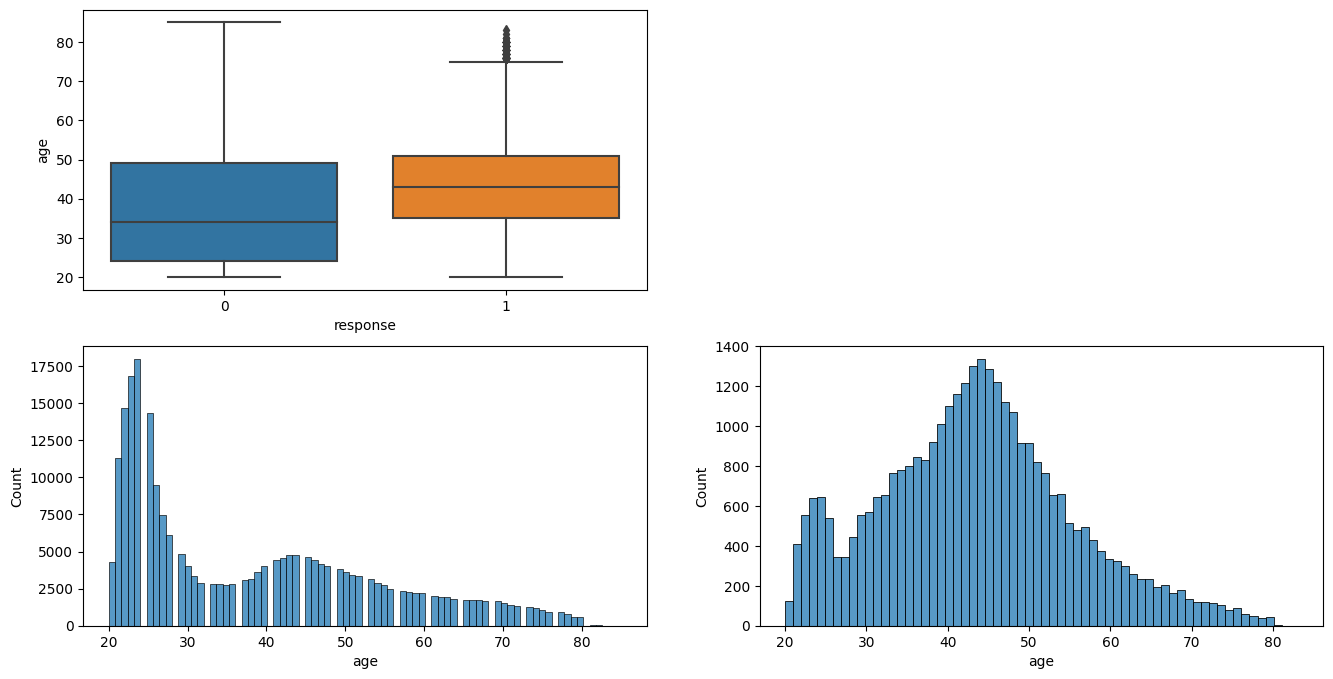

In [30]:
# 'age'
plt.figure( figsize=( 16, 8 ) )
plt.subplot( 2, 2, 1 )
sns.boxplot( x='response', y='age', data=df4 );

aux00 = df4.loc[df4['response'] == 0, 'age']
plt.subplot( 2, 2, 3 )
sns.histplot( aux00 );

aux01 = df4.loc[df4['response'] == 1, 'age']
plt.subplot( 2, 2, 4 )
sns.histplot( aux01 );

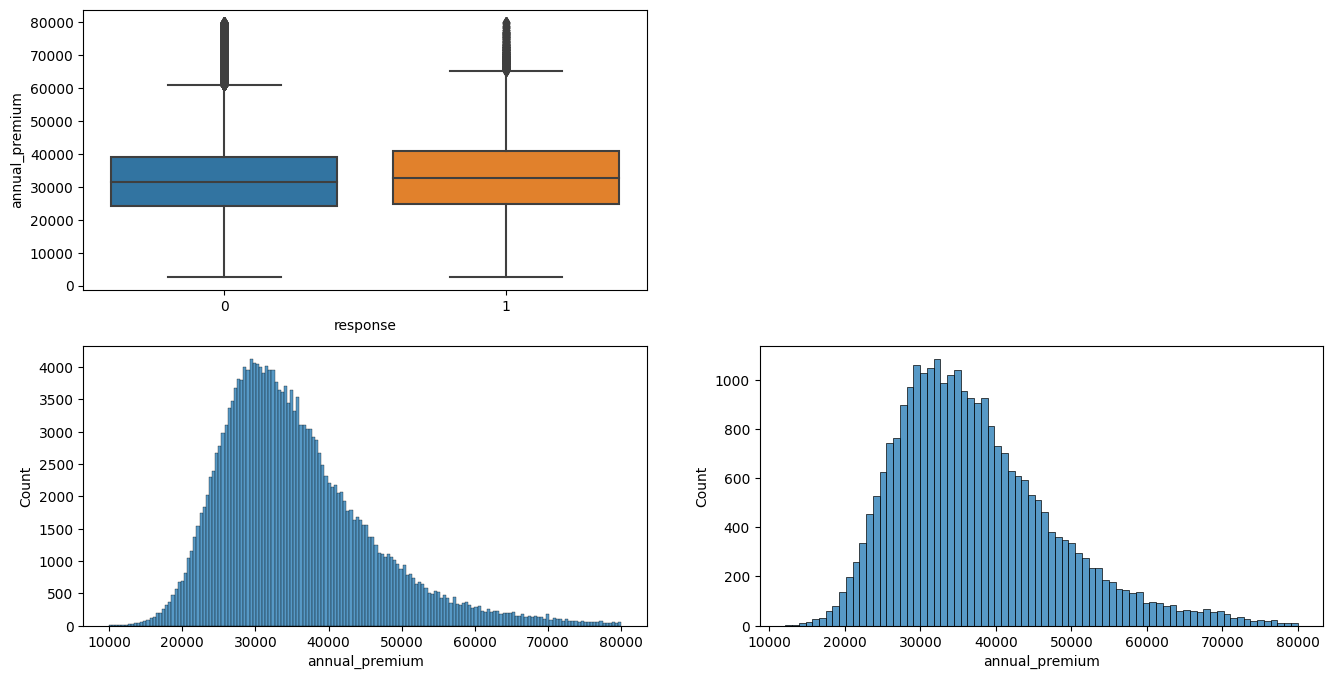

In [31]:
# 'annual_premium'
aux = df4[df4['annual_premium'] < 80000 ]
plt.figure( figsize=( 16, 8 ) )
plt.subplot( 2, 2, 1 )
sns.boxplot( x='response', y='annual_premium', data=aux );

aux = df4[(df4['annual_premium'] > 10000 ) & (df4['annual_premium'] < 80000 )]
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
plt.subplot( 2, 2, 3 )
sns.histplot( aux00 );

aux01 = aux.loc[aux['response'] == 1, 'annual_premium']
plt.subplot( 2, 2, 4 )
sns.histplot( aux01 );

In [32]:
# 'driving_license'
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux
# aux_plt = sns.barplot( x='response', y='driving_license', data=aux);
# aux_plt.set(xticklabels=["pessoas com CNH que não querem seguro", "pessoas com CNH que querem seguro"]);

,response,driving_license,driving_license_perc
0,0,240206,0.87726
1,1,33608,0.12274


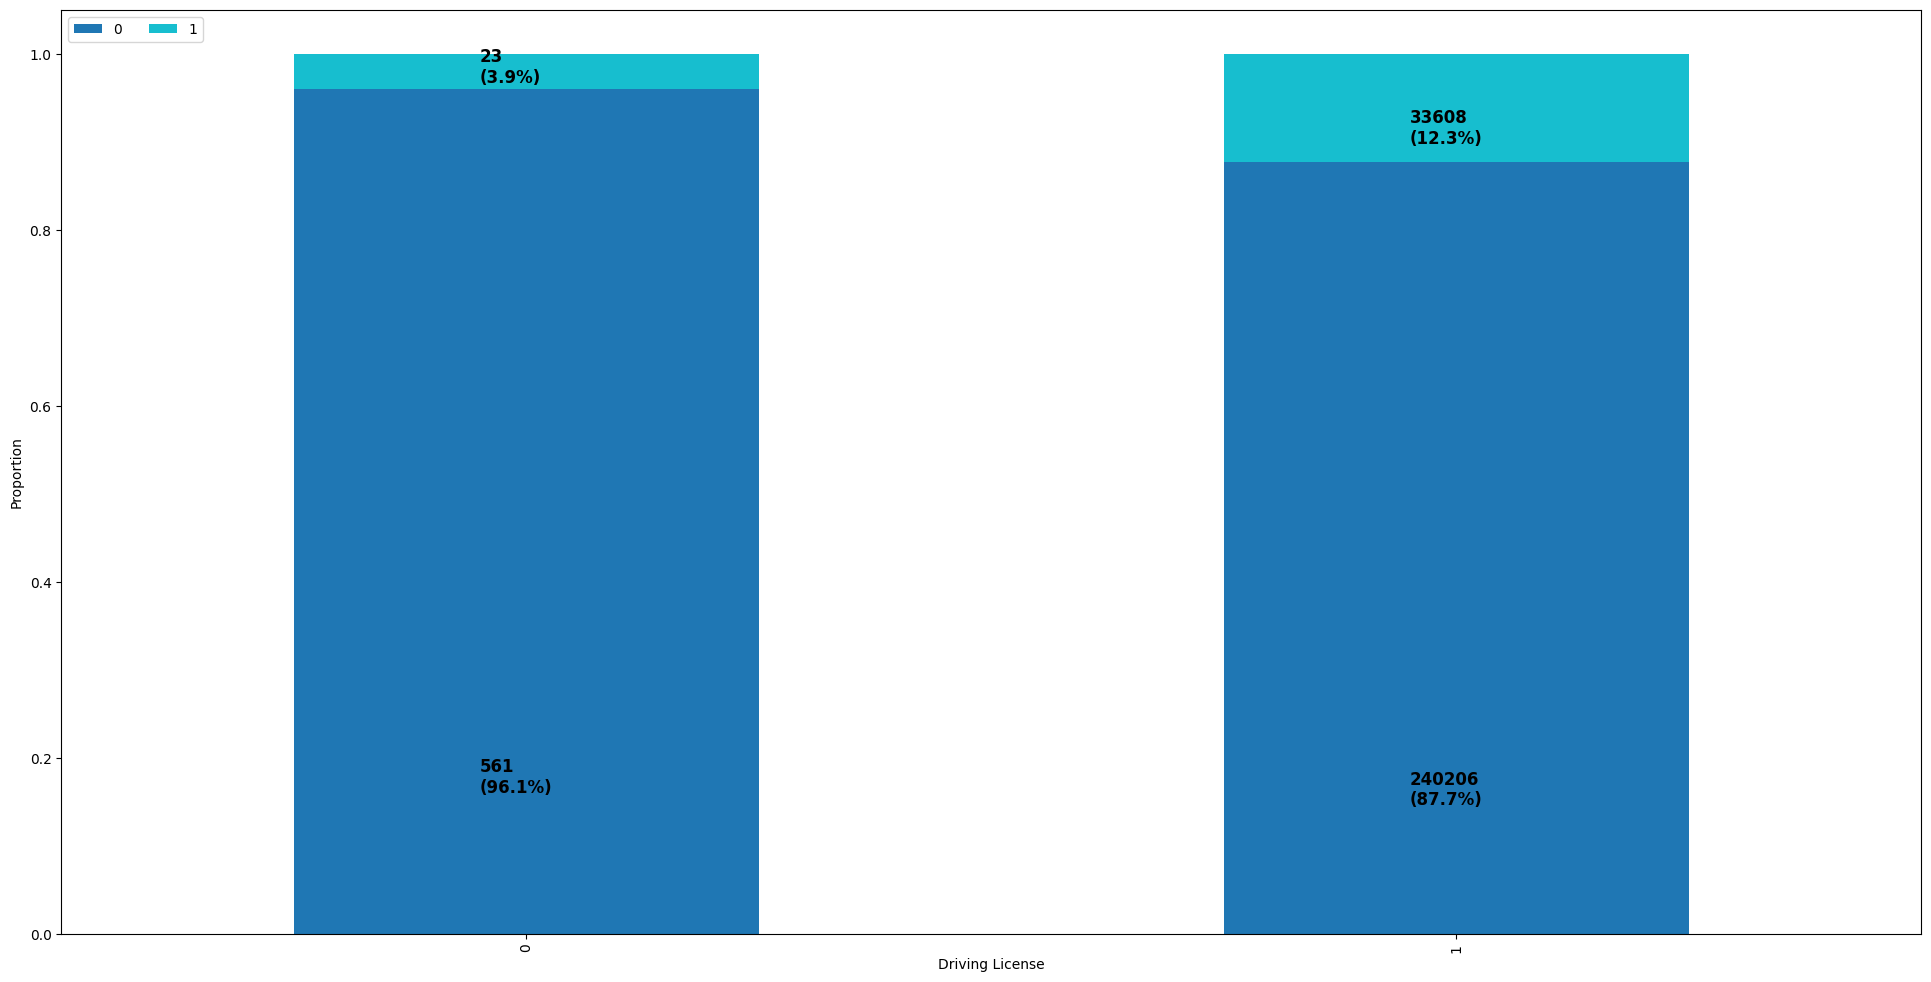

In [33]:
index = df4.driving_license
columns = df4.response
figsize = (24,12)
xlabel = 'Driving License'
text_x_location = 0.05
text_y_location = 6

insurance_functions.stacked_bar(index, columns, figsize, xlabel, text_x_location, text_y_location)

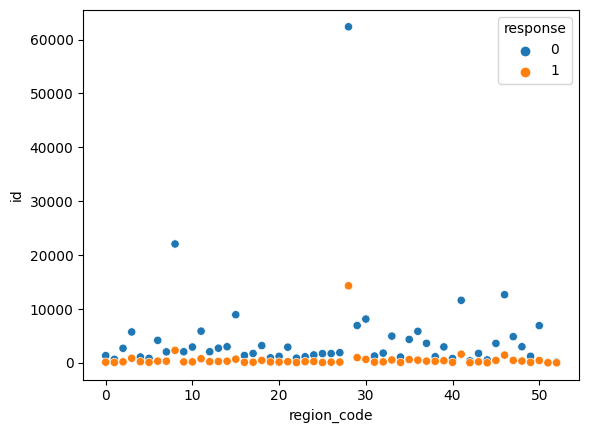

In [34]:
# 'region_code'
# combine with car_damage and preview_insurance
# na vida real voce pode pegar os lat long e fazer uns webscrapping com dados do governo
aux00 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=aux00 );

Male      148241
Female    126157
Name: gender, dtype: int64


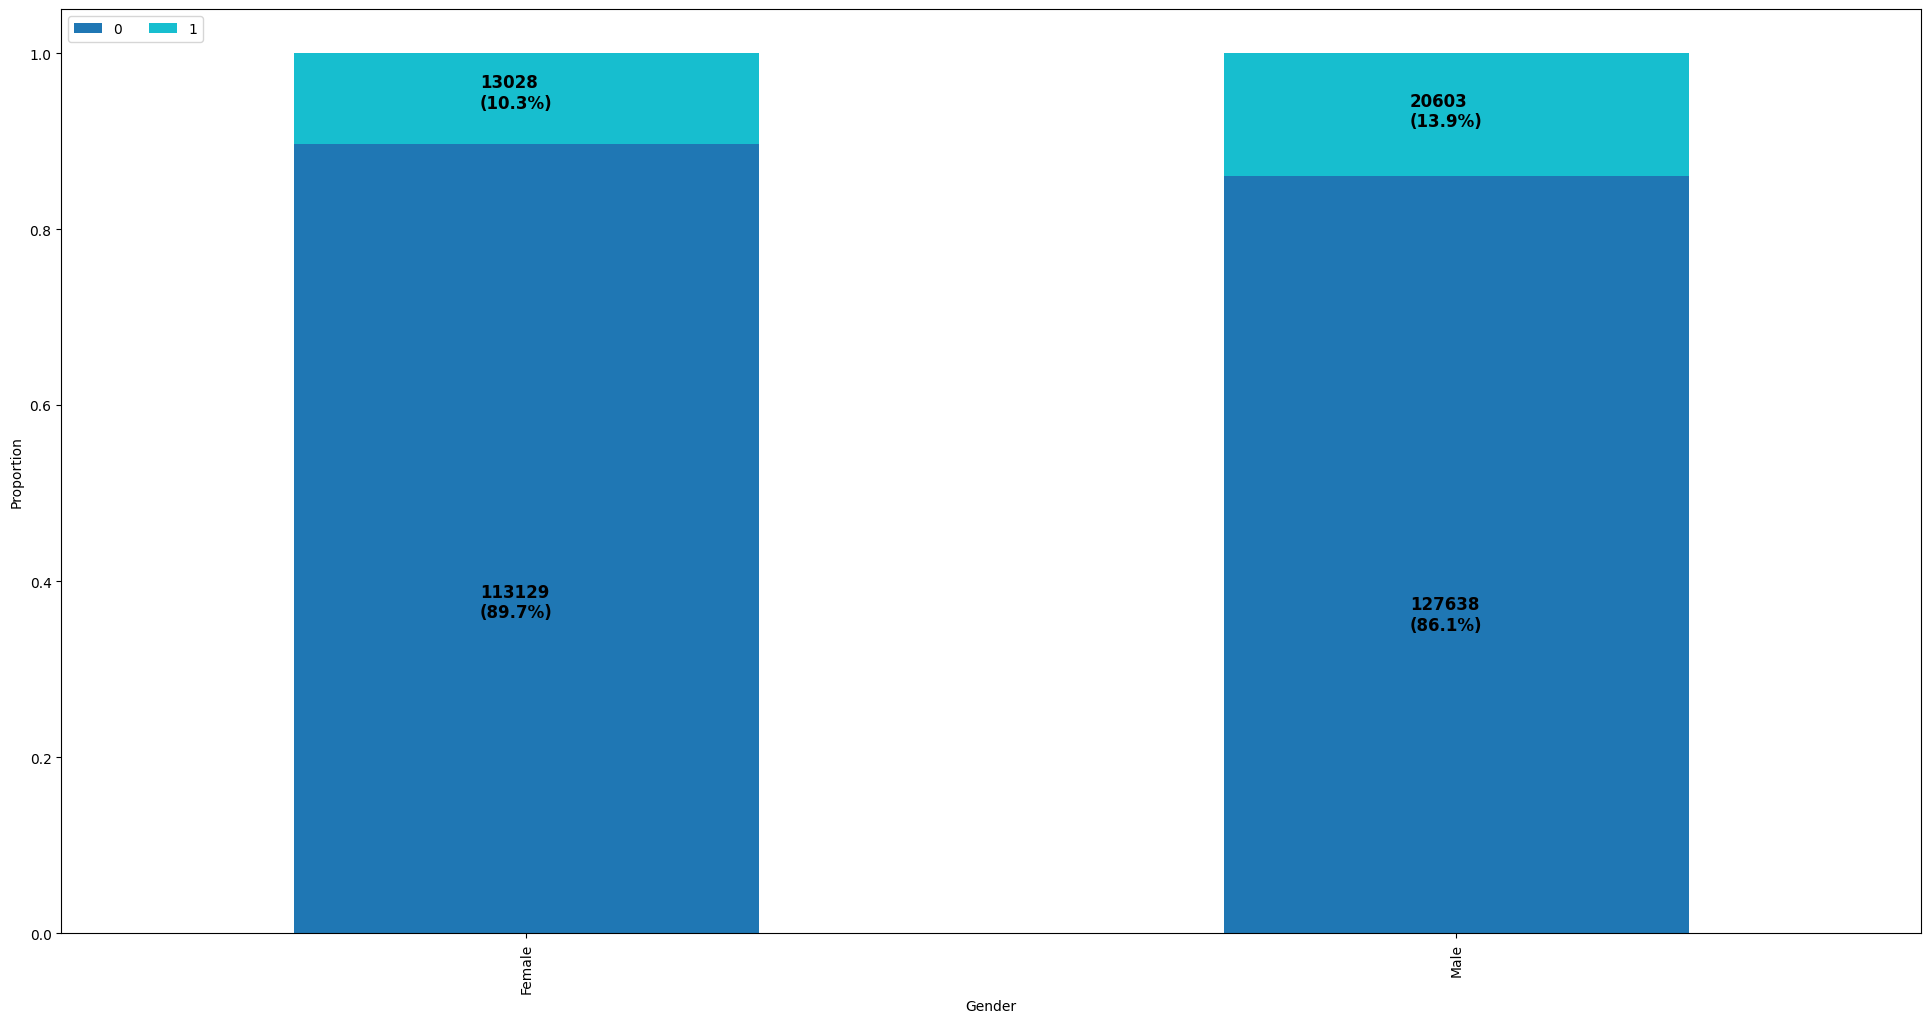

In [35]:
# 'gender'
print( df4.gender.value_counts() )

index = df4.gender
columns = df4.response
figsize = (24,12)
xlabel = 'Gender'
text_x_location = 0.05
text_y_location = 2.5

insurance_functions.stacked_bar(index, columns, figsize, xlabel, text_x_location, text_y_location)

In [36]:
# 'previously_insured'
pd.crosstab(df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774367,0.225633
1,0.999102,0.000898


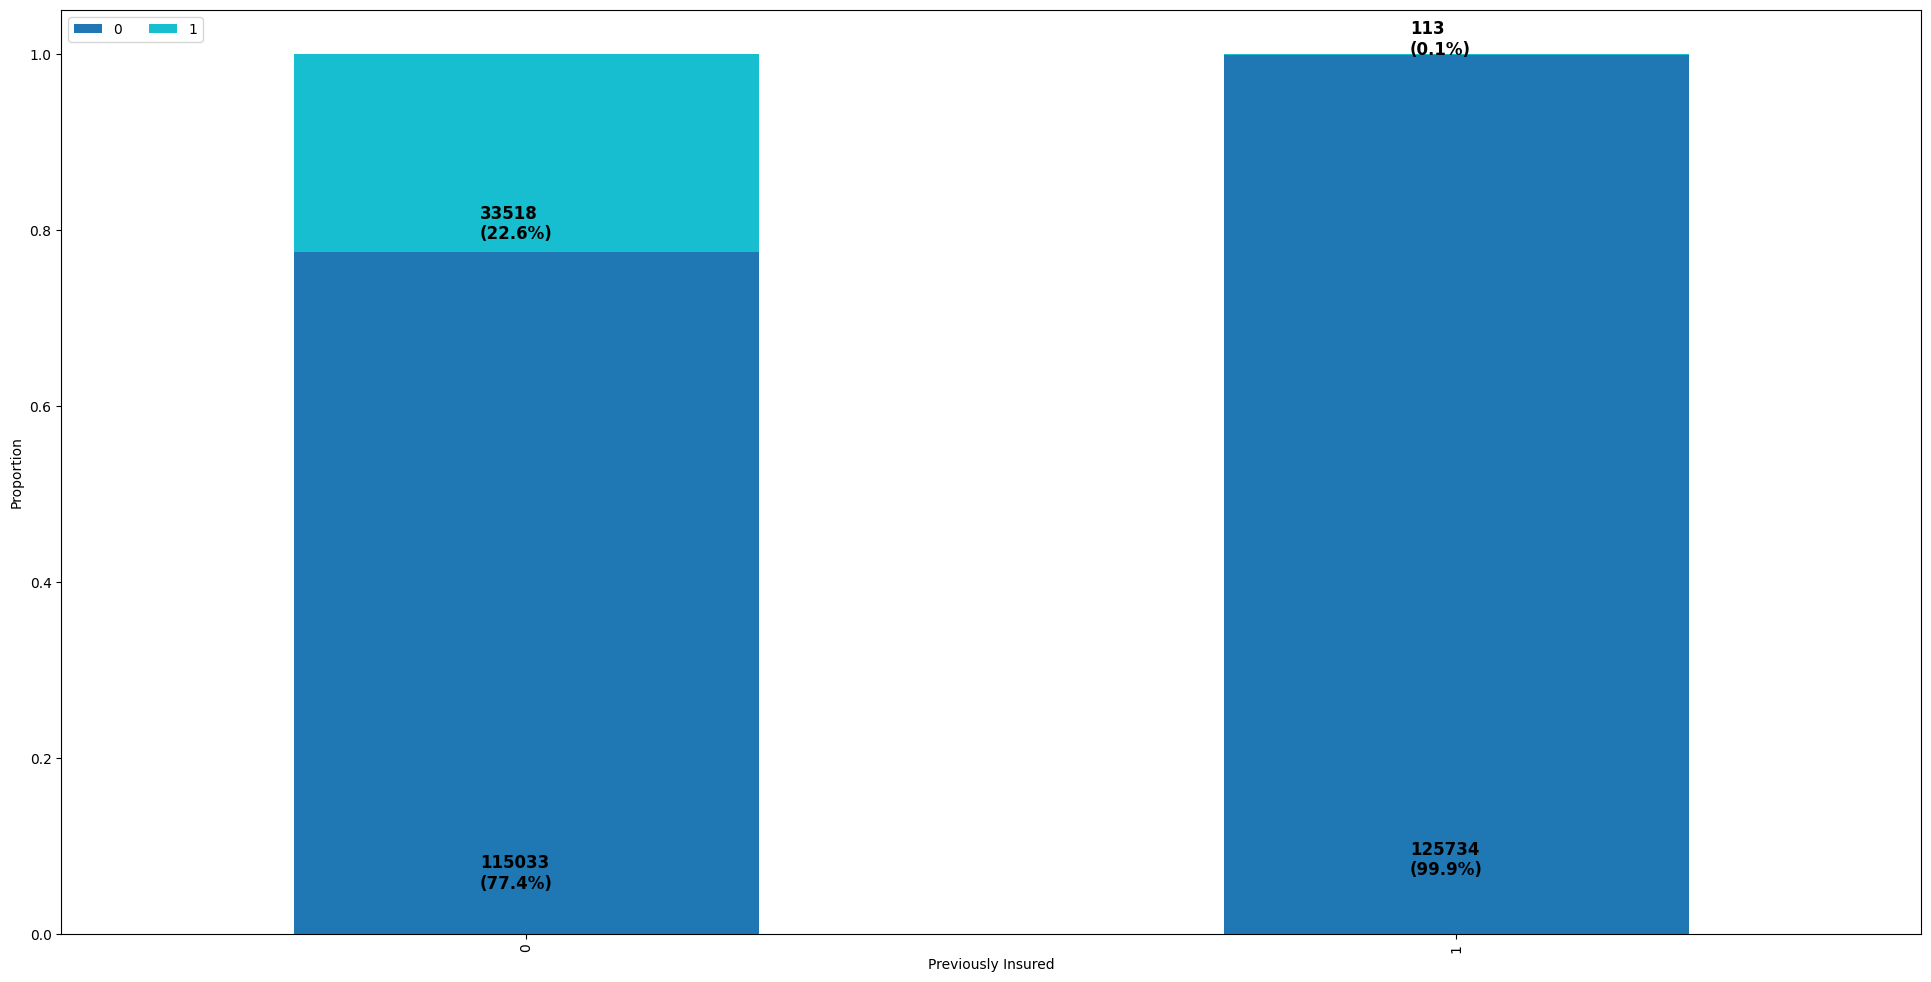

In [37]:
index = df4.previously_insured
columns = df4.response
figsize = (24,12)
xlabel = 'Previously Insured'
text_x_location = 0.05
text_y_location = 15

insurance_functions.stacked_bar(index, columns, figsize, xlabel, text_x_location, text_y_location)

In [38]:
# 'vehicle_age'
df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index().sort_values( 'vehicle_age' )

,vehicle_age,response,0
1,below_1_year,0,0.413902
4,below_1_year,1,0.018761
0,between_1_2_year,0,0.433888
2,between_1_2_year,1,0.091553
3,over_2_years,0,0.029647
5,over_2_years,1,0.012249


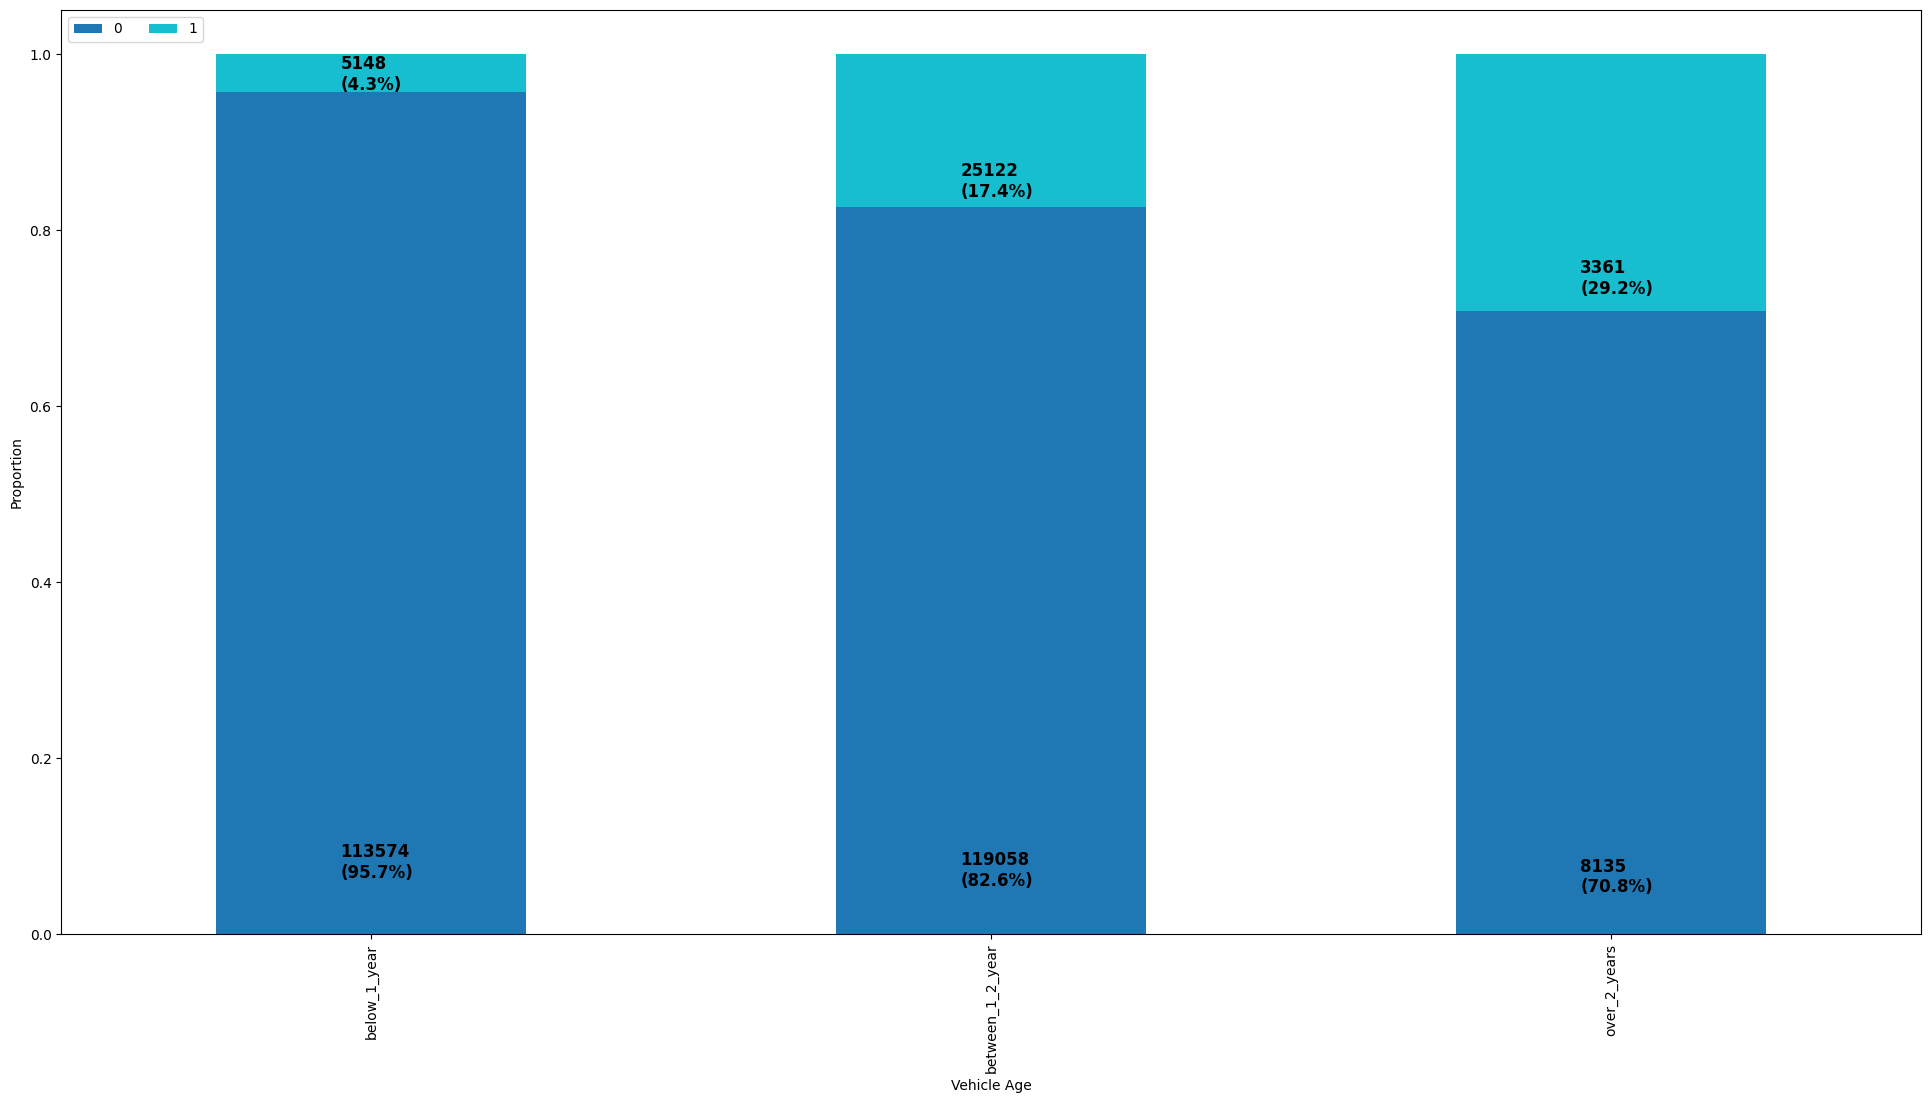

In [39]:
index = df4.vehicle_age
columns = df4.response
figsize = (24,12)
xlabel = 'Vehicle Age'
text_x_location = 0.05
text_y_location = 15

insurance_functions.stacked_bar(index, columns, figsize, xlabel, text_x_location, text_y_location)

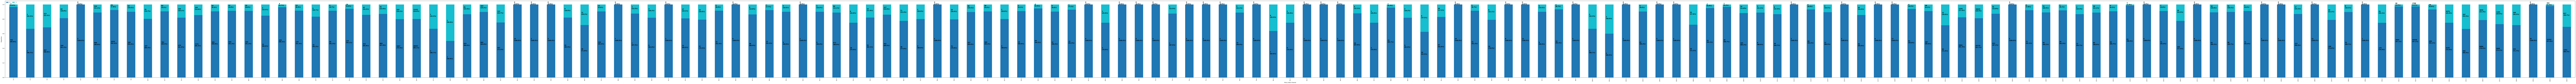

In [40]:
#  'policy_sales_channel'
index = df4.policy_sales_channel
columns = df4.response
figsize = (400,12)
xlabel = 'Policy Sales Channel'
text_y_location = 2
text_x_location = 0.2

insurance_functions.stacked_bar( index, columns, figsize, xlabel, text_x_location,text_y_location )

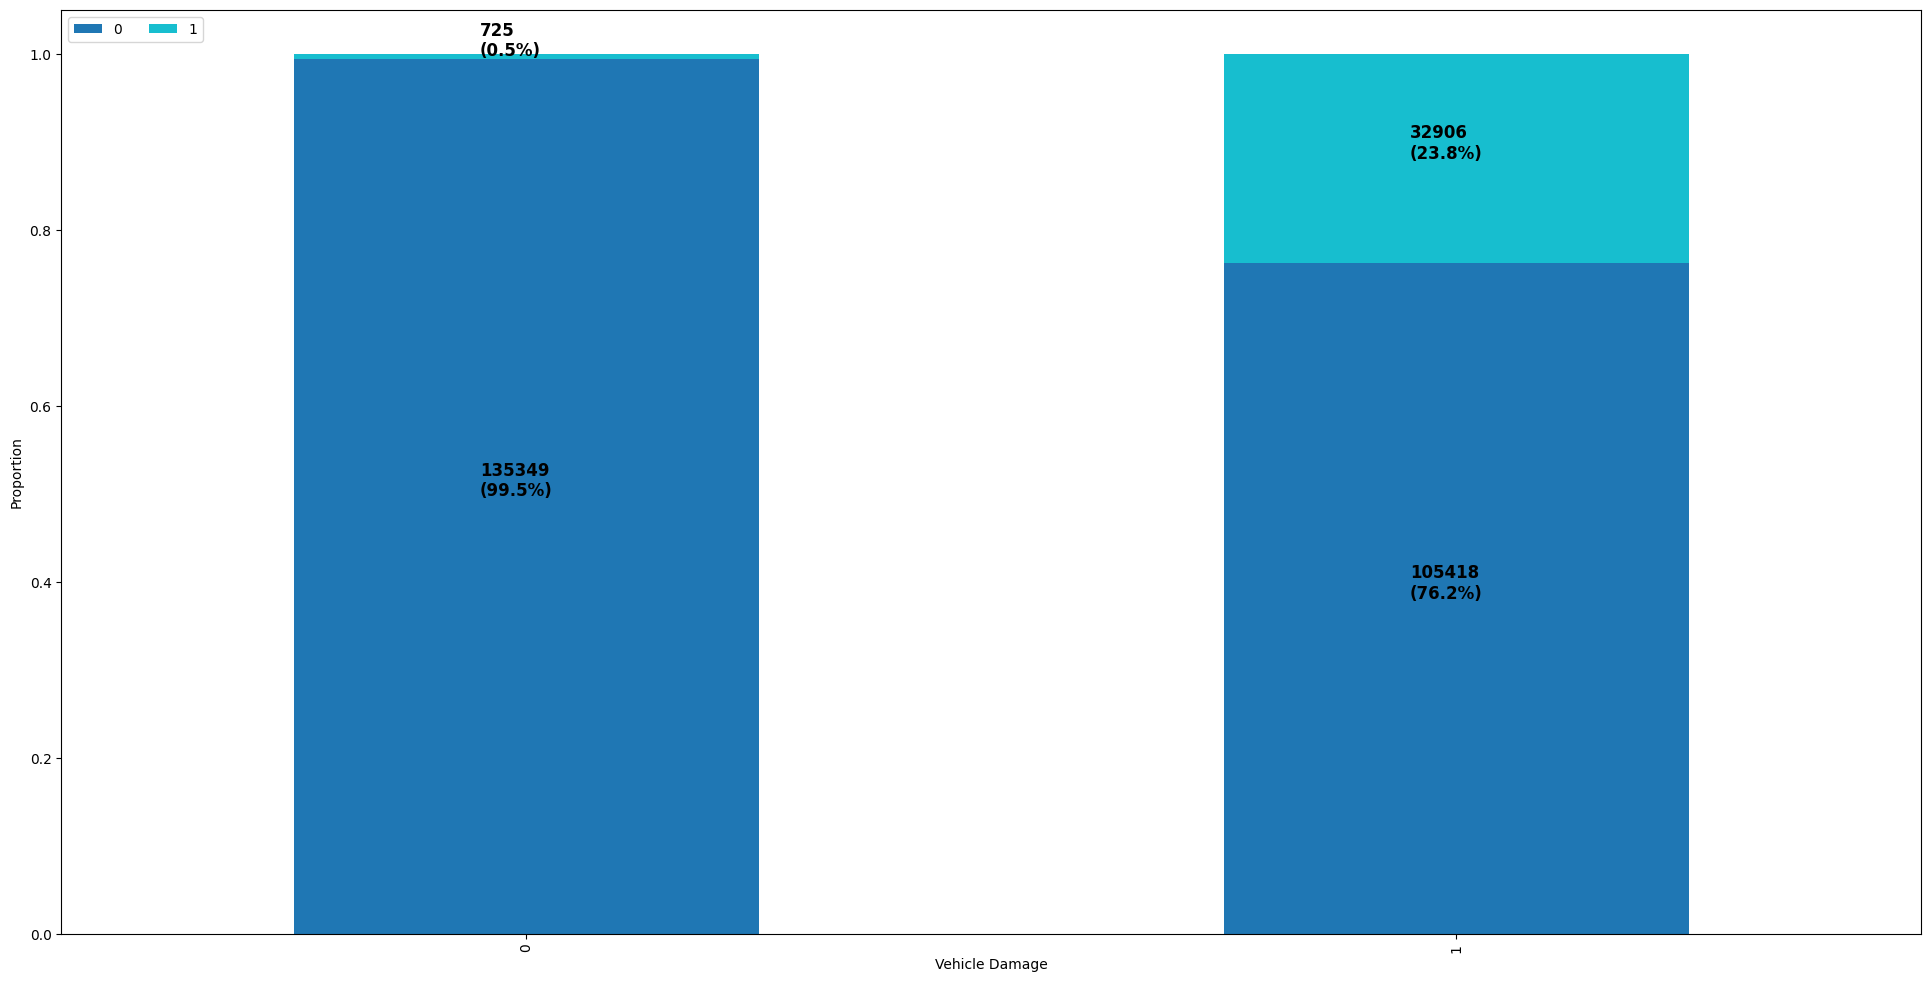

In [41]:
# 'vehicle_damage'
index = df4.vehicle_damage
columns = df4.response
figsize = (24,12)
xlabel = 'Vehicle Damage'
text_y_location = 2
text_x_location = 0.05

insurance_functions.stacked_bar( index, columns, figsize, xlabel, text_x_location,text_y_location )

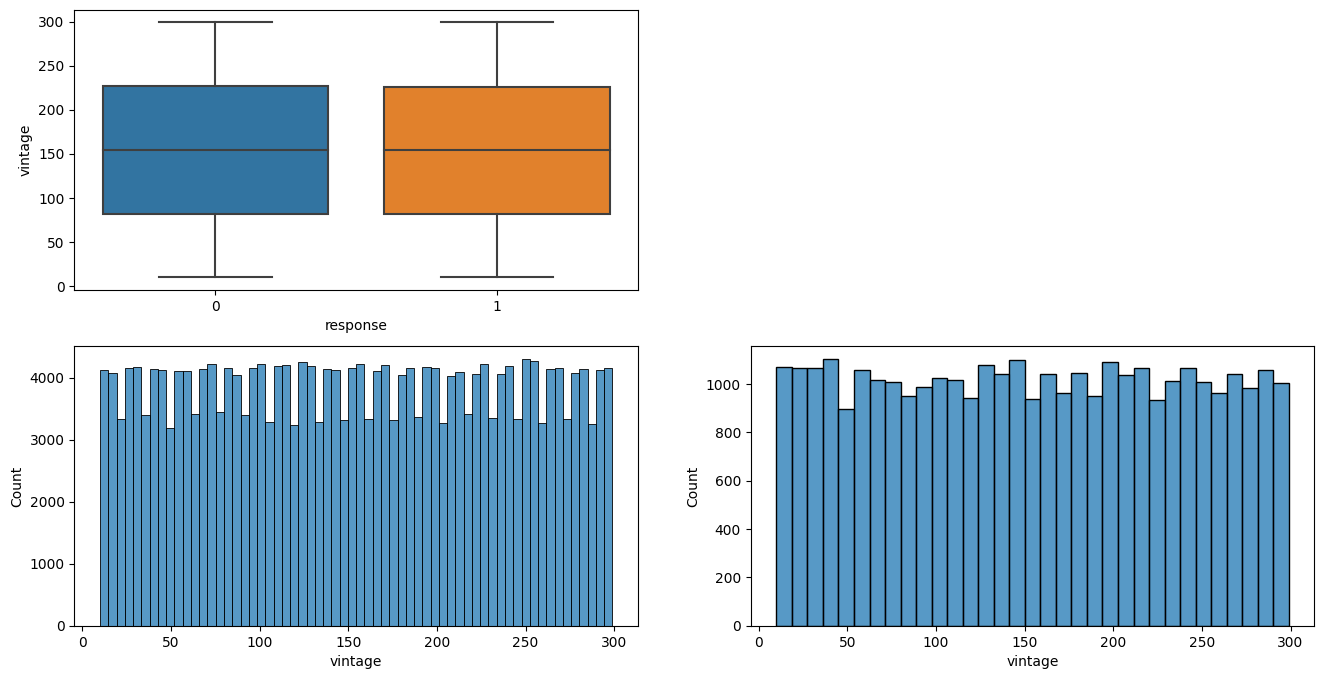

In [42]:
# 'vintage'
plt.figure( figsize=( 16, 8 ) )
plt.subplot( 2, 2, 1 )
sns.boxplot( x='response', y='vintage', data=df4 );

aux00 = df4.loc[df4['response'] == 0, 'vintage']
plt.subplot( 2, 2, 3 )
sns.histplot( aux00 );

aux01 = df4.loc[df4['response'] == 1, 'vintage']
plt.subplot( 2, 2, 4 )
sns.histplot( aux01 );

## 4.3. Hypotheses

### H1 - The most interested customers are women.

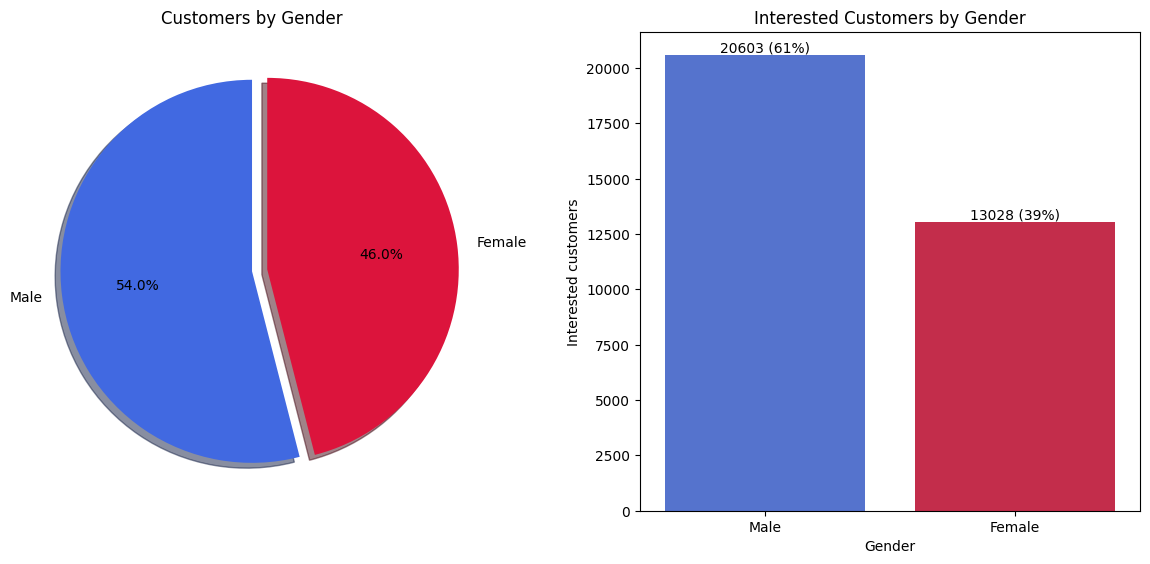

In [43]:
# Gender Interest Dashboard

plt.figure(figsize=(12,6))
colors = ['#4169E1', '#DC143C']

# percentage of customers per gender (PIE)

pie_gender = plt.subplot(1,2,1)
pie_gender.set_title('Customers by Gender')

# get the percentages of the genders
percent_m, percent_f = np.round(df4['gender'].value_counts(normalize=True),3)*100

# pie plot
pie_gender.pie([percent_m, percent_f], explode=(0, 0.08), labels=['Male', 'Female'], autopct='%1.1f%%', shadow=True, startangle=90, colors=colors)

# interested customers per gender (BAR)

bar_gender = plt.subplot(1,2,2)
gender_true = df4[df4['response'] == 1]

gender_response = sns.countplot(x=gender_true['gender'],
                                order=gender_true['gender'].value_counts(ascending=False).index, palette=colors);

# get the percentages of the genders
absolute_values = gender_true['gender'].value_counts(ascending=False)
percent_values = gender_true['gender'].value_counts(ascending=False, normalize=True)*100

# bar label
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(absolute_values, percent_values)]
gender_response.bar_label(container=gender_response.containers[0], labels=lbls);


bar_gender.set_title('Interested Customers by Gender')
bar_gender.set_xlabel('Gender')
bar_gender.set_ylabel('Interested customers')
plt.tight_layout(pad=2)

**FALSE** - 61% of interested customers are male.

### H2 - Interest is most significant when the vehicle is newer.

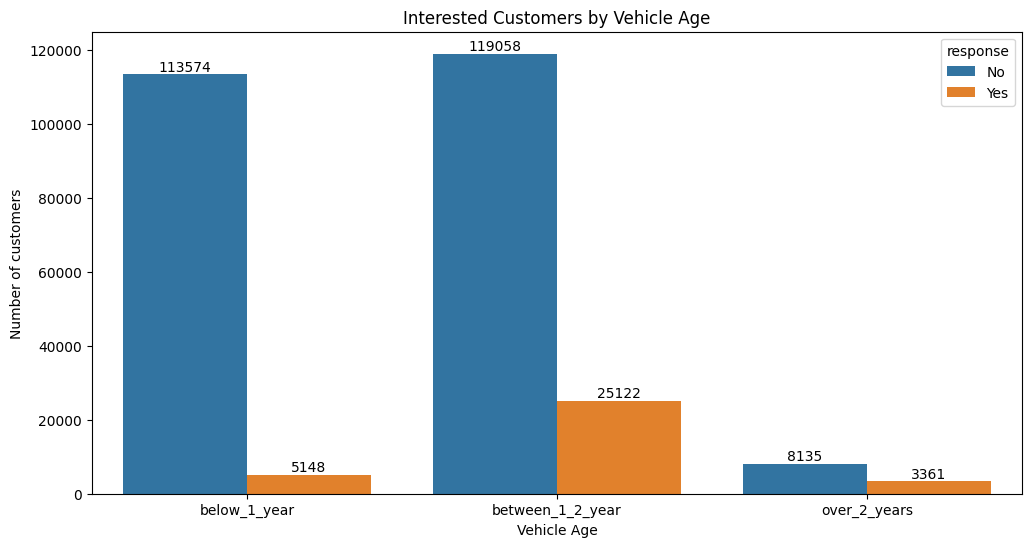

In [44]:
# Vehicle Age Interest Dashboard
plt.figure(figsize=(12,6))

vehicle_age_plt = df4.copy()
vehicle_age_plt['response'] = vehicle_age_plt['response'].apply(lambda x: 'Yes' if x == 1 else 'No')
bar_vehicle_age = sns.countplot(x='vehicle_age', hue='response', data=vehicle_age_plt)

bar_vehicle_age.set_title('Interested Customers by Vehicle Age')
bar_vehicle_age.set_xlabel('Vehicle Age')
bar_vehicle_age.set_ylabel('Number of customers')

bar_vehicle_age.bar_label(bar_vehicle_age.containers[0]);
bar_vehicle_age.bar_label(bar_vehicle_age.containers[1]);

In [45]:
percent_below = df4.query("vehicle_age == 'below_1_year'")['response'].value_counts(normalize=True)*100
print(f'Vehicles with age below 1 year:           No = {np.round(percent_below[0],1)}% | Yes = {np.round(percent_below[1],1)}%')

percent_between = df4.query("vehicle_age == 'between_1_2_year'")['response'].value_counts(normalize=True)*100
print(f'Vehicles with age between 1 and 2 year:   No = {np.round(percent_between[0],1)}% | Yes = {np.round(percent_between[1],1)}%')

percent_over = df4.query("vehicle_age == 'over_2_years'")['response'].value_counts(normalize=True)*100
print(f'Vehicles with age over 2 year:            No = {np.round(percent_over[0],1)}% | Yes = {np.round(percent_over[1],1)}%')

Vehicles with age below 1 year:           No = 95.7% | Yes = 4.3%
Vehicles with age between 1 and 2 year:   No = 82.6% | Yes = 17.4%
Vehicles with age over 2 year:            No = 70.8% | Yes = 29.2%


**FALSE** - The group with the highest number of customers interested in absolute values ​​is the group with vehicles between 1 and 2 years old. And the group with the highest percentage of interested parties is the group with vehicles over 2 years old.

### H2.5 - Interest is most significant when the vehicle is newer.( With customers without vehicle insurance )

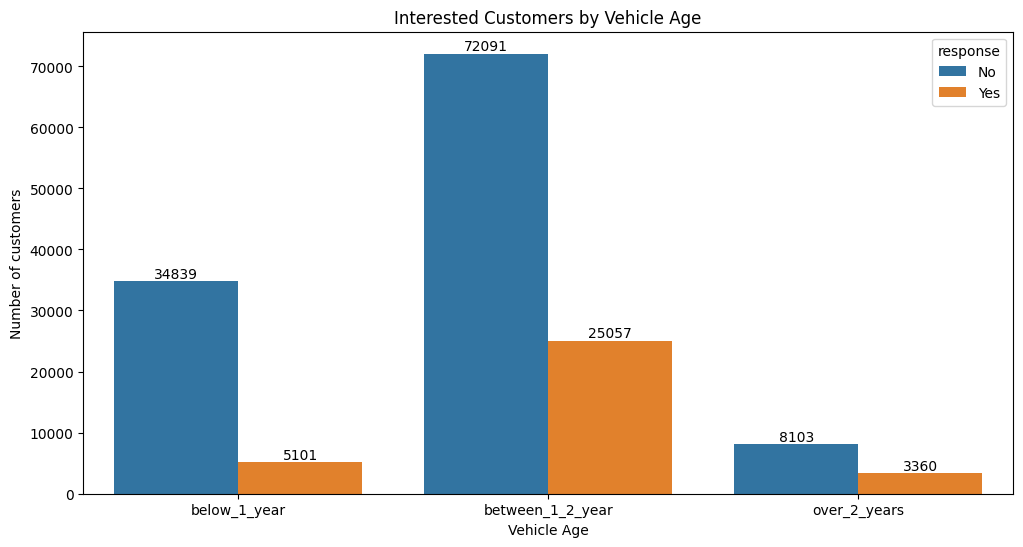

In [46]:
# Vehicle Age Interest Dashboard
plt.figure(figsize=(12,6))

vehicle_age_plt = vehicle_age_plt[vehicle_age_plt['previously_insured'] == 0]
bar_vehicle_age = sns.countplot(x='vehicle_age', hue='response', data=vehicle_age_plt)

bar_vehicle_age.set_title('Interested Customers by Vehicle Age')
bar_vehicle_age.set_xlabel('Vehicle Age')
bar_vehicle_age.set_ylabel('Number of customers')

bar_vehicle_age.bar_label(bar_vehicle_age.containers[0]);
bar_vehicle_age.bar_label(bar_vehicle_age.containers[1]);

In [47]:
percent_below = df4.query("vehicle_age == 'below_1_year' & previously_insured == 0")['response'].value_counts(normalize=True)*100
print(f'Vehicles with age below 1 year:           No = {np.round(percent_below[0],1)}% | Yes = {np.round(percent_below[1],1)}%')

percent_between = df4.query("vehicle_age == 'between_1_2_year' & previously_insured == 0")['response'].value_counts(normalize=True)*100
print(f'Vehicles with age between 1 and 2 year:   No = {np.round(percent_between[0],1)}% | Yes = {np.round(percent_between[1],1)}%')

percent_over = df4.query("vehicle_age == 'over_2_years' & previously_insured == 0")['response'].value_counts(normalize=True)*100
print(f'Vehicles with age over 2 year:            No = {np.round(percent_over[0],1)}% | Yes = {np.round(percent_over[1],1)}%')

Vehicles with age below 1 year:           No = 87.2% | Yes = 12.8%
Vehicles with age between 1 and 2 year:   No = 74.2% | Yes = 25.8%
Vehicles with age over 2 year:            No = 70.7% | Yes = 29.3%


**FALSE** - In this case, we verify that even if the customer has insurance, the group with vehicles aged between 1 and 2 years is the highest.

### H3 - Customers without a driver's license are less interested.

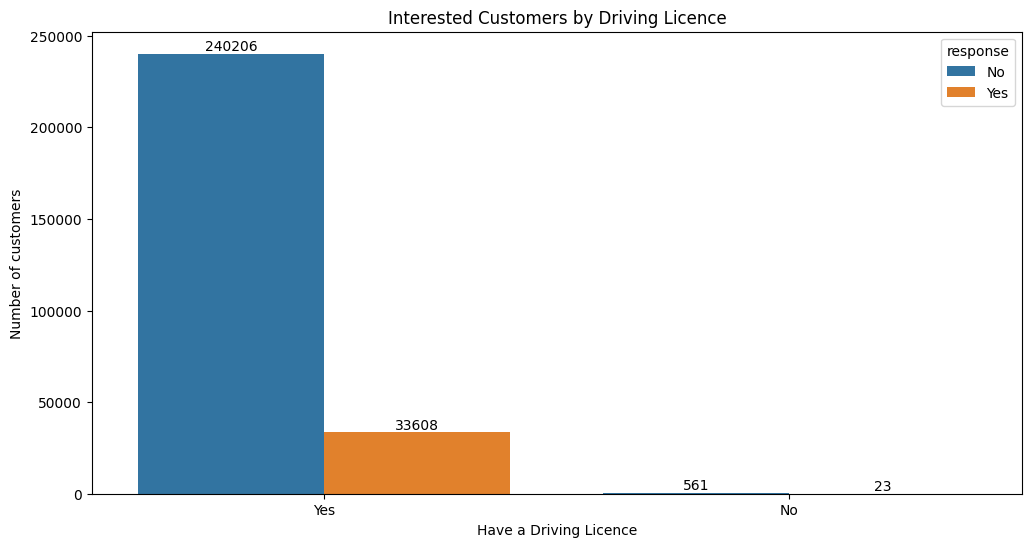

In [48]:
# Driving License Interest Dashboard
plt.figure(figsize=(12,6))

driving_license_plt = df4.copy()
driving_license_plt['response'] = driving_license_plt['response'].apply(lambda x: 'Yes' if x == 1 else 'No')
driving_license_plt['driving_license'] = driving_license_plt['driving_license'].apply(lambda x: 'Yes' if x == 1 else 'No')
bar_driving_license = sns.countplot(x='driving_license', hue='response', data=driving_license_plt)

bar_driving_license.set_title('Interested Customers by Driving Licence')
bar_driving_license.set_xlabel('Have a Driving Licence')
bar_driving_license.set_ylabel('Number of customers')

bar_driving_license.bar_label(bar_driving_license.containers[0]);
bar_driving_license.bar_label(bar_driving_license.containers[1]);

In [49]:
percent_license = df4.query("driving_license == 1")['response'].value_counts(normalize=True)*100
print(f'Vehicles with Driving License:            No = {np.round(percent_license[0],1)}% | Yes = {np.round(percent_license[1],1)}%')

percent_license = df4.query("driving_license == 0")['response'].value_counts(normalize=True)*100
print(f'Vehicles without Driving License:         No = {np.round(percent_license[0],1)}% | Yes = {np.round(percent_license[1],1)}%')

Vehicles with Driving License:            No = 87.7% | Yes = 12.3%
Vehicles without Driving License:         No = 96.1% | Yes = 3.9%


**TRUE** - Customers without a driving license are less interested

### H4 - Older customers are more interested.

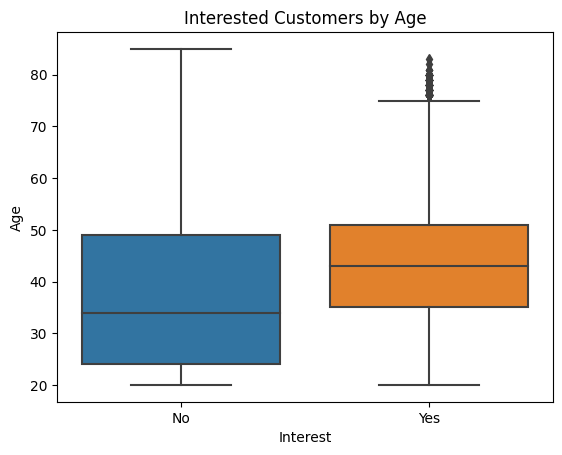

In [50]:
# Distribution of interested by age
boxplot_age = sns.boxplot(x = 'response', y= 'age', data = df4)
boxplot_age.set_xticklabels(['No', 'Yes'])
boxplot_age.set_ylabel('Age')
boxplot_age.set_xlabel('Interest')
boxplot_age.set_title('Interested Customers by Age');


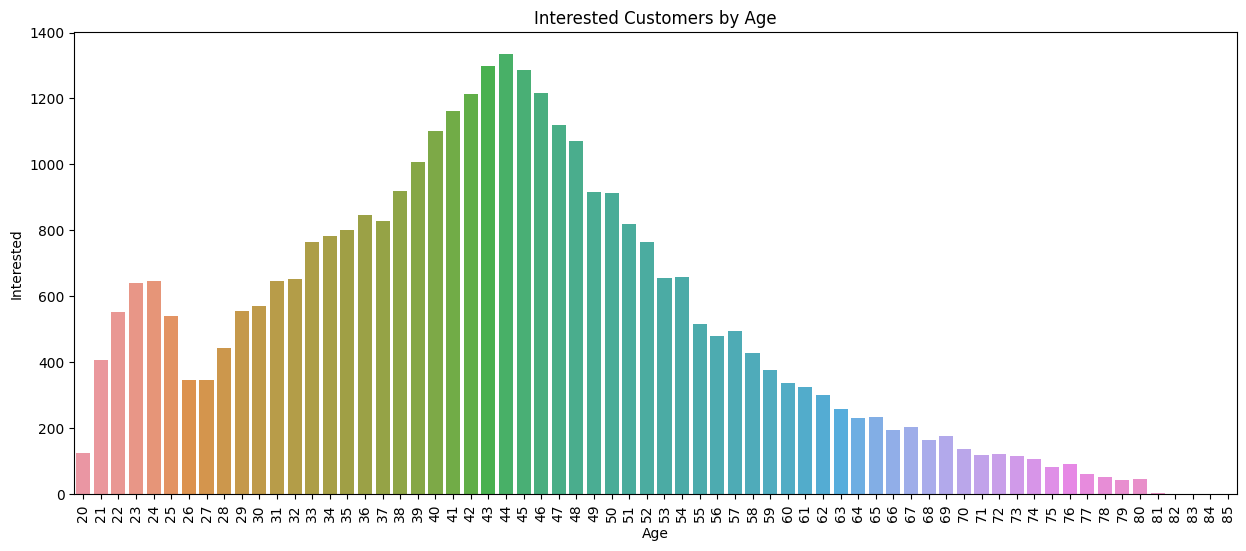

In [51]:
# Analyse just interested customers by age
plt.figure(figsize=(15,6))
aux_age = df4[['age', 'response']].groupby('age').sum().reset_index()
bar_age = sns.barplot( x='age', y='response', data=aux_age )
bar_age.set_title('Interested Customers by Age')
bar_age.set_xlabel('Age')
bar_age.set_ylabel('Interested')
plt.xticks( rotation=90 );

**FALSE** - The largest group of interested customers is between 41 and 45 years old.

### H5 - Customers with a history of vehicle damage are most interested.

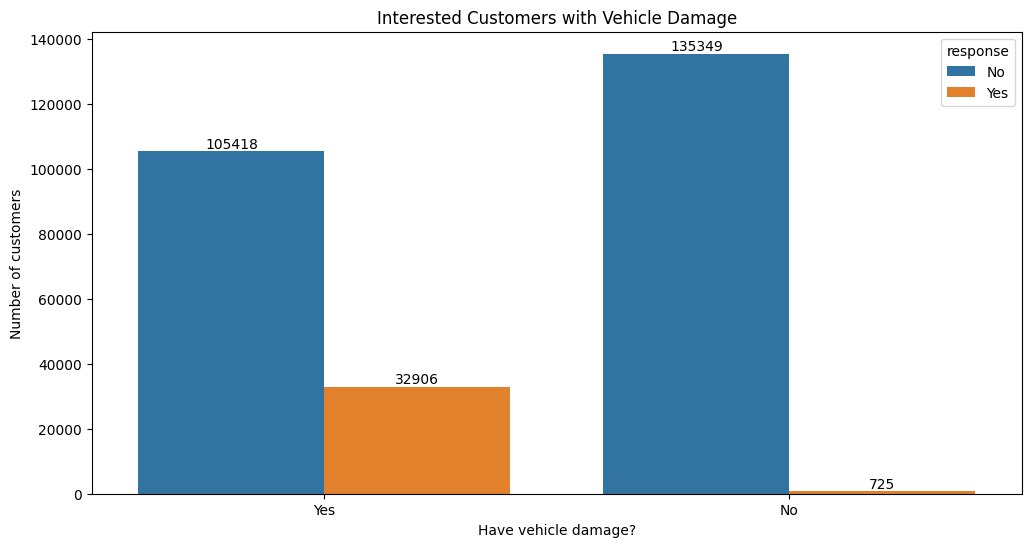

In [52]:
# Driving License Interest Dashboard
plt.figure(figsize=(12,6))

vehicle_damage_plt = df4.copy()
vehicle_damage_plt['response'] = vehicle_damage_plt['response'].apply(lambda x: 'Yes' if x == 1 else 'No')
vehicle_damage_plt['vehicle_damage'] = vehicle_damage_plt['vehicle_damage'].apply(lambda x: 'Yes' if x == 1 else 'No')
bar_vehicle_damage = sns.countplot(x='vehicle_damage', hue='response', data=vehicle_damage_plt)

bar_vehicle_damage.set_title('Interested Customers with Vehicle Damage')
bar_vehicle_damage.set_xlabel('Have vehicle damage?')
bar_vehicle_damage.set_ylabel('Number of customers')

bar_vehicle_damage.bar_label(bar_vehicle_damage.containers[0]);
bar_vehicle_damage.bar_label(bar_vehicle_damage.containers[1]);

In [53]:
percent_license = df4.query("vehicle_damage == 1")['response'].value_counts(normalize=True)*100
print(f'Vehicles with Vehicle Damage:            No = {np.round(percent_license[0],1)}% | Yes = {np.round(percent_license[1],1)}%')

percent_license = df4.query("vehicle_damage == 0")['response'].value_counts(normalize=True)*100
print(f'Vehicles without Vehicle Damage:         No = {np.round(percent_license[0],1)}% | Yes = {np.round(percent_license[1],1)}%')

Vehicles with Vehicle Damage:            No = 76.2% | Yes = 23.8%
Vehicles without Vehicle Damage:         No = 99.5% | Yes = 0.5%


**TRUE** - Customers with a history of vehicle damage are most interested.

### H6 - Customers with expensive health plans are more interested.

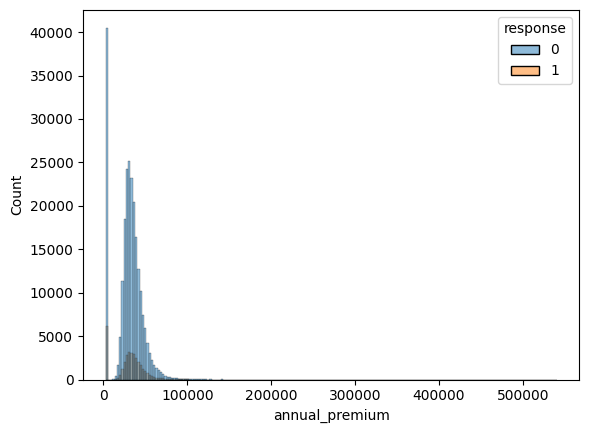

In [54]:
sns.histplot(x='annual_premium', hue='response', data=df4, bins=200);

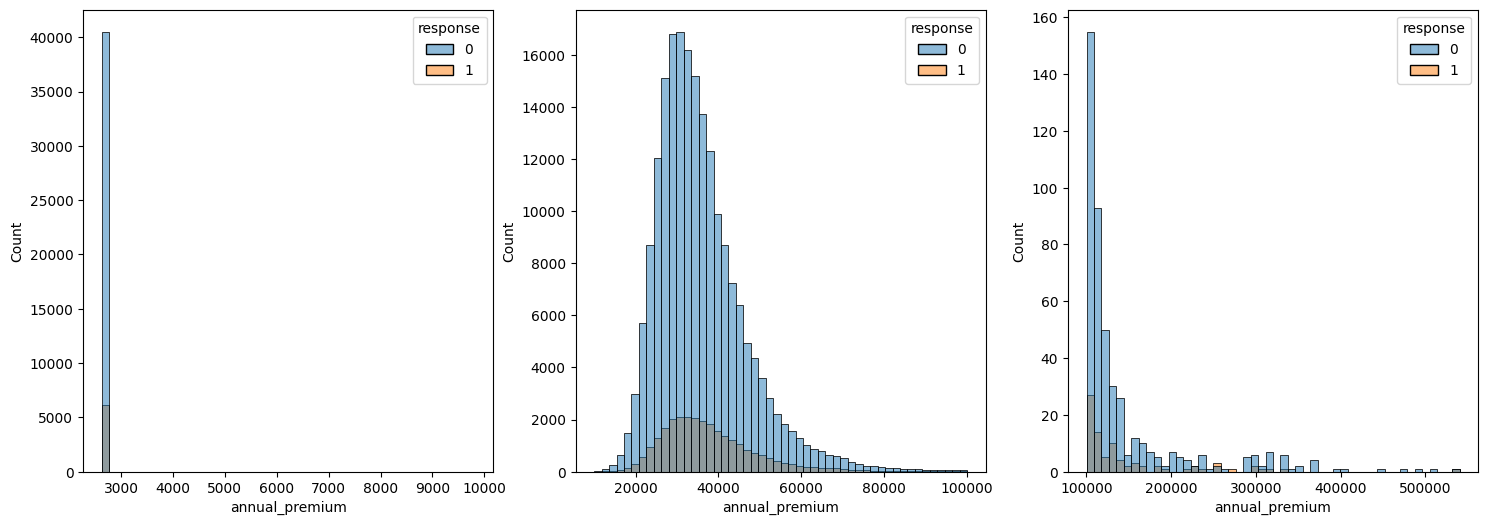

In [55]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
ax4= df4[df4['annual_premium']<10000]
sns.histplot(x='annual_premium', hue='response', data=ax4, bins=50)


plt.subplot(1,3,2)
ax5= df4[(df4['annual_premium']>=10000) & (df4['annual_premium']<100000)]
sns.histplot(x='annual_premium', hue='response', data=ax5, bins=50)

plt.subplot(1,3,3)
ax6= df4[df4['annual_premium']>=100000]
sns.histplot(x='annual_premium', hue='response', data=ax6, bins=50);

**FALSE** - The highest frequency of interested customers have health plans that cost below 3000.

### H7 - Customers with vehicle insurance are less interested.

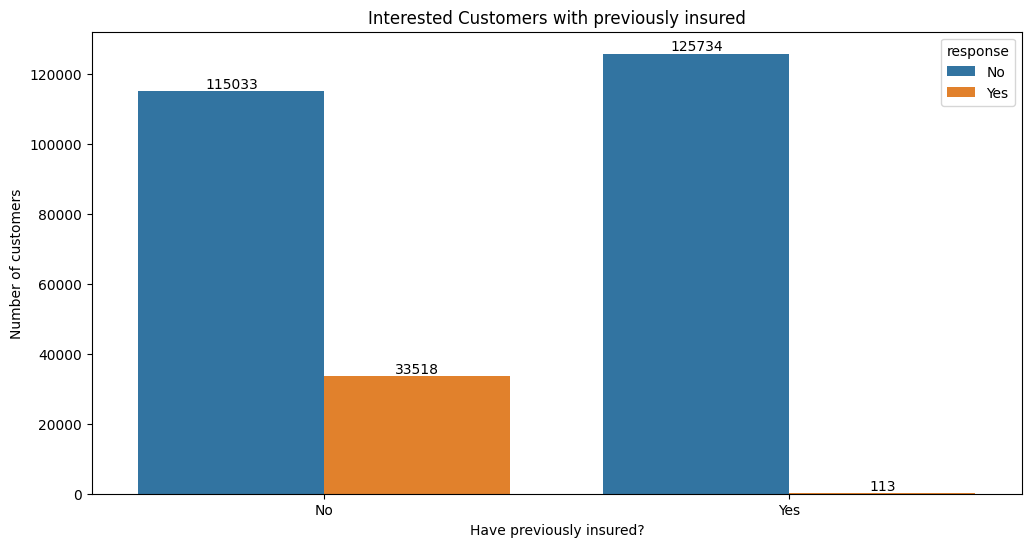

In [56]:
# Driving License Interest Dashboard
plt.figure(figsize=(12,6))

previously_insured_plt = df4.copy()
previously_insured_plt['response'] = previously_insured_plt['response'].apply(lambda x: 'Yes' if x == 1 else 'No')
previously_insured_plt['previously_insured'] = previously_insured_plt['previously_insured'].apply(lambda x: 'Yes' if x == 1 else 'No')
bar_previously_insured = sns.countplot(x='previously_insured', hue='response', data=previously_insured_plt)

bar_previously_insured.set_title('Interested Customers with previously insured')
bar_previously_insured.set_xlabel('Have previously insured?')
bar_previously_insured.set_ylabel('Number of customers')

bar_previously_insured.bar_label(bar_previously_insured.containers[0]);
bar_previously_insured.bar_label(bar_previously_insured.containers[1]);

In [57]:
percent_license = df4.query("previously_insured == 1")['response'].value_counts(normalize=True)*100
print(f'Vehicles with previously insured:            No = {np.round(percent_license[0],1)}% | Yes = {np.round(percent_license[1],1)}%')

percent_license = df4.query("previously_insured == 0")['response'].value_counts(normalize=True)*100
print(f'Vehicles without previously insured:         No = {np.round(percent_license[0],1)}% | Yes = {np.round(percent_license[1],1)}%')

Vehicles with previously insured:            No = 99.9% | Yes = 0.1%
Vehicles without previously insured:         No = 77.4% | Yes = 22.6%


**TRUE** - Customers who already have vehicle insurance, are not interested in a second insurance.

### H8 - The most used channel is the channel with the most interested customers.

,policy_sales_channel,number_of_customers,converted_customer,percent
24,26,57498,11441,0.198981
117,124,53171,10035,0.188731
143,152,97246,2788,0.028670


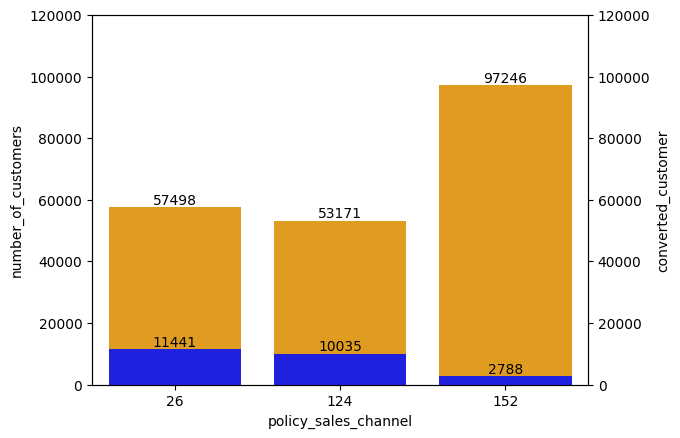

In [58]:
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').count().reset_index()
aux['policy_sales_channel'] = aux['policy_sales_channel'].astype(int)
aux['converted_customer'] =  df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()['response']
aux = aux[aux['response'] > 20000]
aux = aux.rename(columns={'policy_sales_channel': 'policy_sales_channel', 'response': 'number_of_customers', 'converted_customer': 'converted_customer'})
aux['percent'] = aux['converted_customer'] / aux['number_of_customers']

ax1 = sns.barplot(x='policy_sales_channel', y='number_of_customers', data=aux, color='orange')
ax1.set_ylim([0,120000])
ax1.bar_label(ax1.containers[0]);

# # set up the 2nd axis
ax12 = ax1.twinx()
ax2 = sns.barplot(x='policy_sales_channel', y='converted_customer', data=aux, color='blue', ax=ax12)
ax2.set_ylim([0,120000]);
ax2.bar_label(ax2.containers[0])


aux

**FALSE** - Although channel 152 is the most used, customers are not interested in vehicle insurance. It would be interesting to investigate this channel to find out what causes it to have a low conversion rate.

# 5.0. Data Preparation

In [59]:
df5 = pd.read_csv('data/saved_data/df2.csv')
x_val = pd.read_csv('data/saved_data/X_val.csv')

## 5.1. Standardization

In [60]:
ss = pp.StandardScaler()

# Annual Premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

## 5.2. Rescaling

In [61]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# Vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )

## 5.3. Encoder

In [62]:
# Gender
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )

# Region Code - Frequency Encoding / < Target Encoding > /  Weighted Target Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )

# Vehicle Age - < One Hot Encoding > / Order Enconding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# Policy Sales Channel - Target Encoding / < Frequency Encoding >
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 )
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )

## 5.4. Validation Preparation

In [63]:
# Gender
x_val.loc[:, 'gender'] = x_val.loc[:, 'gender'].map( target_encode_gender )

# Age
x_val.loc[:, 'age'] = mms_age.transform( x_val[['age']].values )

# Region Code
x_val.loc[:, 'region_code'] = x_val.loc[:, 'region_code'].map( target_encode_region_code )

# Vehicle Age
x_val = pd.get_dummies( x_val, prefix='vehicle_age', columns=['vehicle_age'] )

# Annual Premium
x_val.loc[:, 'annual_premium'] = ss.transform( x_val[['annual_premium']].values )

# Policy Sales Channel
x_val.loc[:, 'policy_sales_channel'] = x_val.loc[:, 'policy_sales_channel'].map( fe_policy_sales_channel )

# Vintage
x_val.loc[:, 'vintage'] = mms_vintage.transform( x_val[['vintage']].values )

# Fill NA
x_val = x_val.fillna( 0 )

In [64]:
df5.to_csv('data/saved_data/df5.csv', index=False)

x_val.to_csv('data/saved_data/x_val_pp.csv', index=False)

# 6.0. Feature Selection

## 6.2. Features importance

In [65]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.271794
0                annual_premium    0.242323
0                           age    0.164686
0                   region_code    0.107695
0                vehicle_damage    0.068287
0          policy_sales_channel    0.059998
0            previously_insured    0.056286
0      vehicle_age_below_1_year    0.014239
0  vehicle_age_between_1_2_year    0.006970
0                        gender    0.005003
0      vehicle_age_over_2_years    0.002167
0               driving_license    0.000553


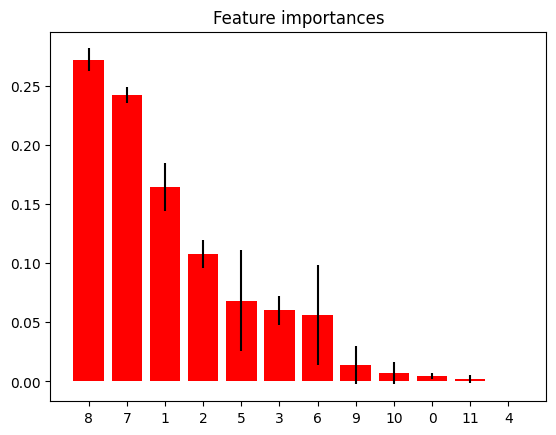

In [66]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0 Machine Learning

In [11]:
# Collect the data
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

df5 = pd.read_csv('data/saved_data/df5.csv')
x_val = pd.read_csv('data/saved_data/x_val_pp.csv')

x_train = df5[ cols_selected ]
y_train = df5['response']

x_val1 = x_val[ cols_selected ]
y_val = pd.read_csv('data/saved_data/y_val.csv')

k = int(x_val.shape[0]*0.4)

In [12]:
y_perfect = pickle.load( open('data/model_performance/yhat_perfect.pkl', 'rb'))

### In this project, 7 machine learning algorithms were tested. Tests can be viewed on other notebooks. To organize the project, in this notebook we can see the results of all the models below.

In [13]:
# Results of precision and recall at k - train => validation
pd.read_csv('data/model_performance/model_performance.csv').sort_values('Precision', ascending=False)

,Model,Precision,Recall
7,LGBMClassifier,0.282331,0.921430
3,Gradient Boosting Classifier,0.281839,0.919824
4,XGBoost Classifier,0.280134,0.914258
6,Balanced Random Forest Classifier,0.278658,0.909441
5,Random Forest Classifier,0.273443,0.892421
0,KNN,0.270458,0.882680
2,Extra Trees,0.268654,0.876793
1,Logistic Regression,0.267441,0.872832


In [14]:
# Results of precision and recall at k - Stratified Cross Validation
pd.read_csv('data/model_performance/model_performance_cross_validation.csv').sort_values('Precision_mean', ascending=False)

,Model,Precision_mean,Precision_std,Recall_mean,Recall_std
6,LGBMClassifier,0.282666,0.000640,0.922522,0.002087
3,XGBoost,0.280967,0.000878,0.916977,0.002865
5,Balanced Random Forest Classifier CV,0.280344,0.000430,0.914943,0.001402
4,Random Forest,0.274696,0.000472,0.896510,0.001542
0,KNN,0.271160,0.000383,0.884971,0.001250
2,Extra Tress,0.270950,0.000453,0.884286,0.001478
1,Logistic Regression,0.267257,0.000075,0.872233,0.000243


## Logistic Regression

In [15]:
# model definition
lr_model = lm.LogisticRegression(penalty='elasticnet', C=0.01, class_weight='balanced', solver='saga', 
                                l1_ratio=0, random_state=0)

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val1 )

In [16]:
lr_score = insurance_functions.make_score(x_val, y_val, yhat_lr)

# compute precision at K
precision_at_n_k = insurance_functions.precision_at_k( lr_score, k=k )
print( f'Precision at K: {precision_at_n_k}' )

# compute recall at K
recall_at_n_k = insurance_functions.recall_at_k( lr_score, k=k )
print( f'Recall    at K: {recall_at_n_k}')

Precision at K: 0.2710542618709231
Recall    at K: 0.8846336822074216


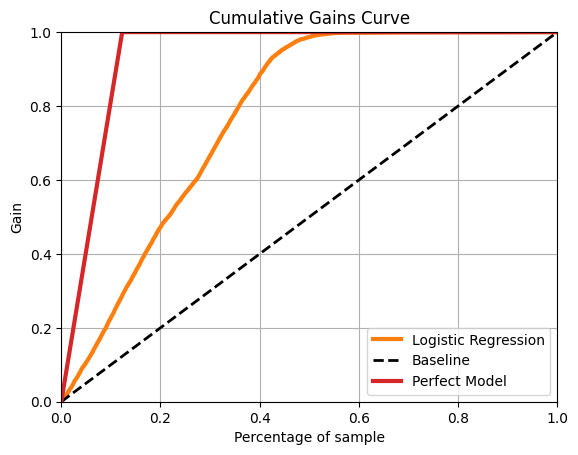

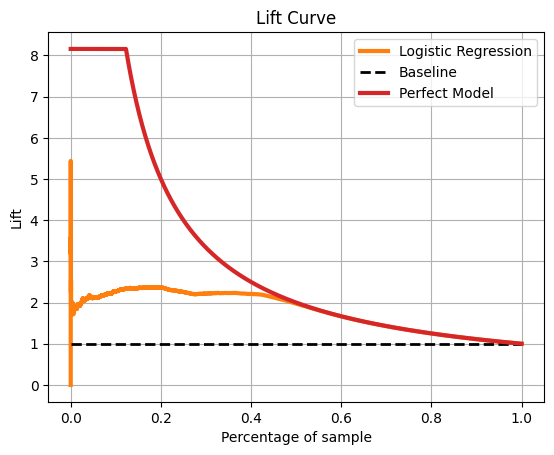

In [18]:
insurance_functions.cumulative_curve2( y_val, yhat_lr, a,"Logistic Regression")
insurance_functions.lift_curve2( y_val, yhat_lr, a,"Logistic Regression")

## LightGBM

In [19]:
# model definition
lgbm = LGBMClassifier(learning_rate=0.00621, num_leaves=51, 
                         min_child_samples=67, subsample=0.938762, 
                         colsample_bytree=0.861679, random_state=0, subsample_freq=1,
                         n_estimators=1000, class_weight='balanced')

# model fit
lgbm.fit( x_train, y_train )

# model predict
yhat_lgbm = lgbm.predict_proba( x_val1 )

In [20]:
lgbm_score = insurance_functions.make_score(x_val, y_val, yhat_lgbm)

# compute precision at K
precision_at_n_k = insurance_functions.precision_at_k( lgbm_score, k=k )
print( f'Precision at K: {precision_at_n_k}' )

# compute recall at K
recall_at_n_k = insurance_functions.recall_at_k( lgbm_score, k=k )
print( f'Recall    at K: {recall_at_n_k}')

Precision at K: 0.2836995736306986
Recall    at K: 0.9259039010466222


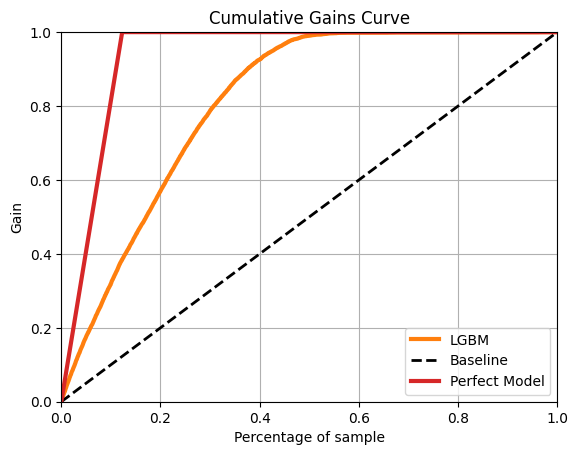

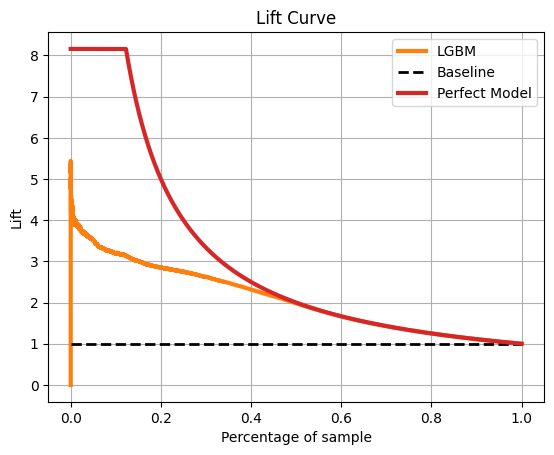

In [21]:
insurance_functions.cumulative_curve2( y_val, yhat_lgbm, a,"LGBM")
insurance_functions.lift_curve2( y_val, yhat_lgbm, a,"LGBM")

# 8.0. Model Performance

In [22]:
pd.read_csv('data/model_performance/perfect_modelmetrics.csv')

,Model,K Sample,Percent of Sample,Precision,Perfect Precision,Recall,Perfect Recall
0,lgbm,7622,0.1,0.386331,1.000000,0.315243,0.815992
1,lgbm,15244,0.2,0.352247,0.612791,0.574823,1.000000
2,lgbm,22866,0.3,0.320156,0.408536,0.783665,1.000000
3,lgbm,30488,0.4,0.282987,0.306406,0.923571,1.000000
4,lgbm,38111,0.5,0.242365,0.245120,0.988760,1.000000


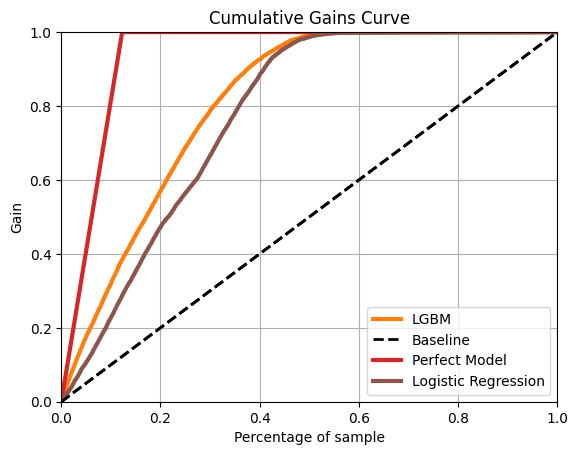

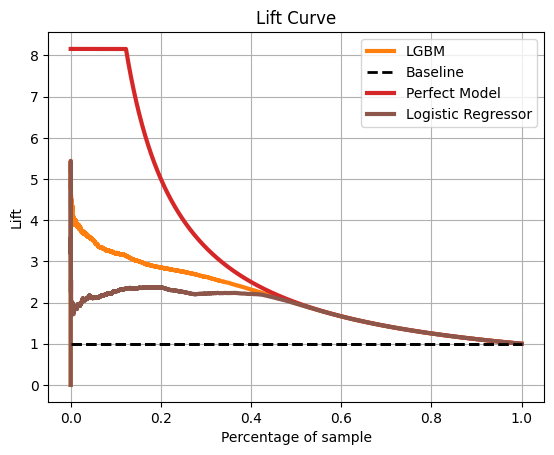

In [23]:
insurance_functions.cumulative_curve3(y_val, yhat_lgbm, yhat_lr, y_perfect, 'LGBM', 'Logistic Regression')
insurance_functions.lift_curve3( y_val, yhat_lgbm, yhat_lr, y_perfect,'LGBM', 'Logistic Regressor')

# The best point in percent of samples to maximize profit

In [24]:
# append dataframes for cross-validation
cv_x = pd.concat([x_train, x_val1])
cv_y = pd.concat([pd.DataFrame(y_train), y_val])

# dataset for cross validation
dataset = cv_x
dataset['response'] = cv_y

k = int(x_val.shape[0]*0.4)

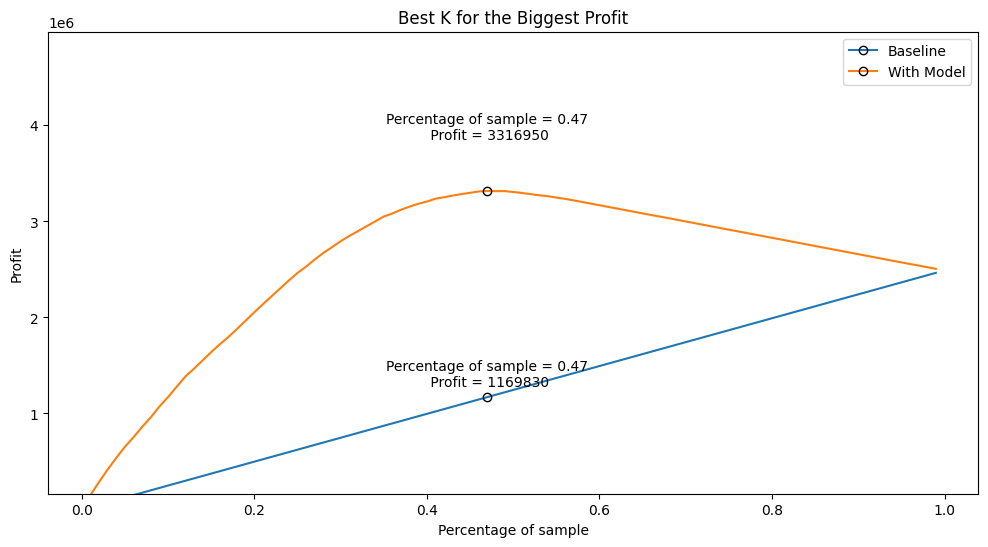

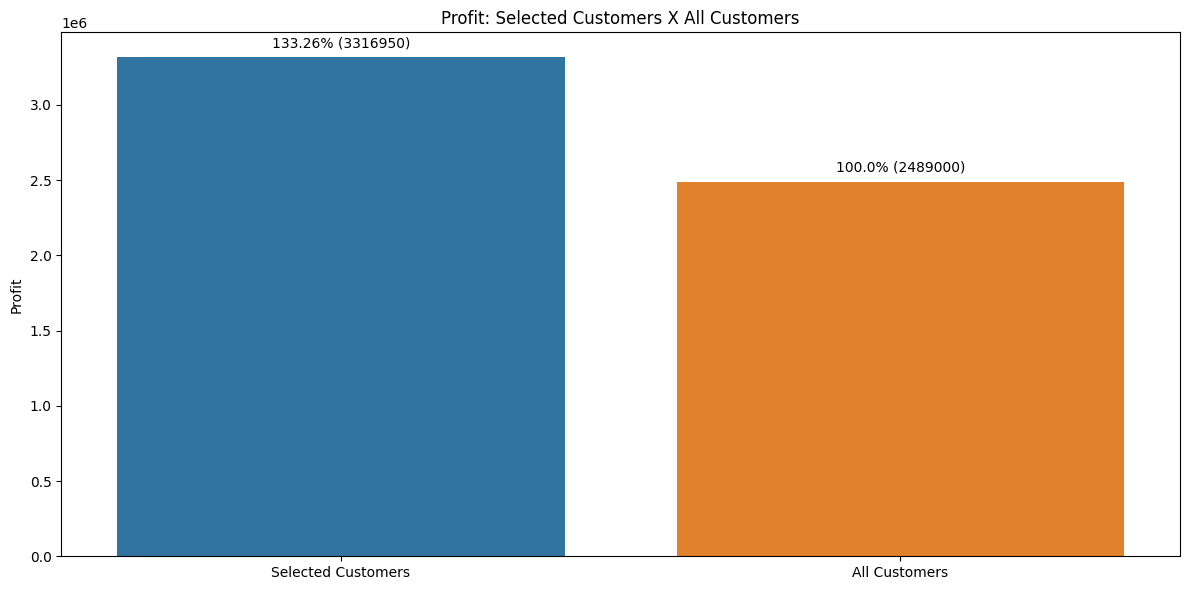

In [25]:
insurance_price = 500
deal_cost = 25

df_base = insurance_functions.make_score(x_val, y_val, yhat_lgbm)

df_profit = insurance_functions.profit_dataframe(data=df_base, insurance_price=insurance_price, deal_cost=deal_cost)

line = insurance_functions.line_profit(df_profit);
bar = insurance_functions.profit_bar(df_base, insurance_price, deal_cost);

In [26]:
insurance_price = 500
deal_cost = 25

Number of fold 1
Number of fold 2
Number of fold 3
Number of fold 4
Number of fold 5
Number of fold 6
Number of fold 7
Number of fold 8
Number of fold 9
Number of fold 10


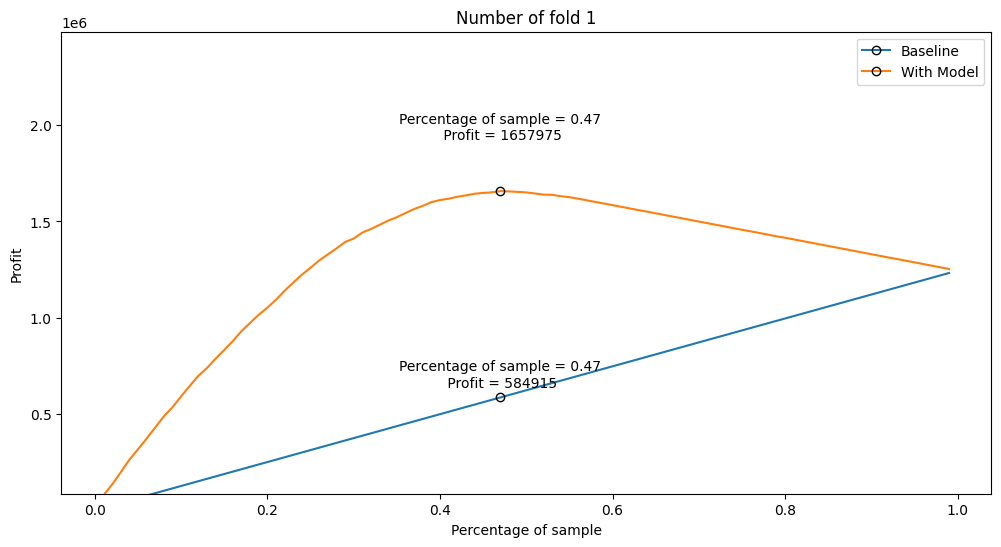

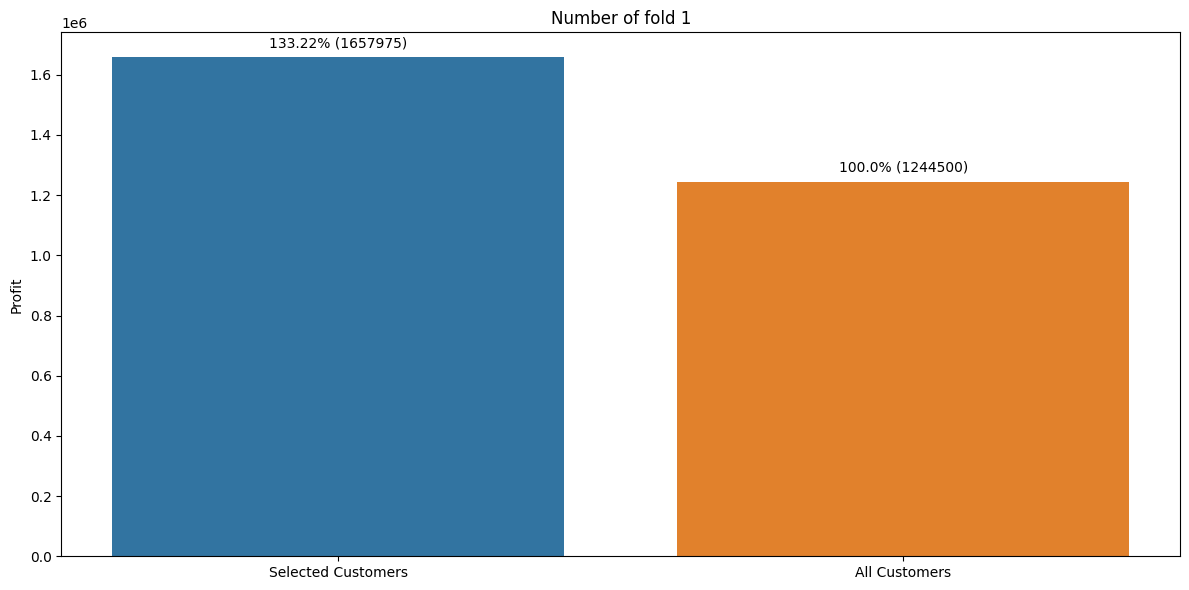

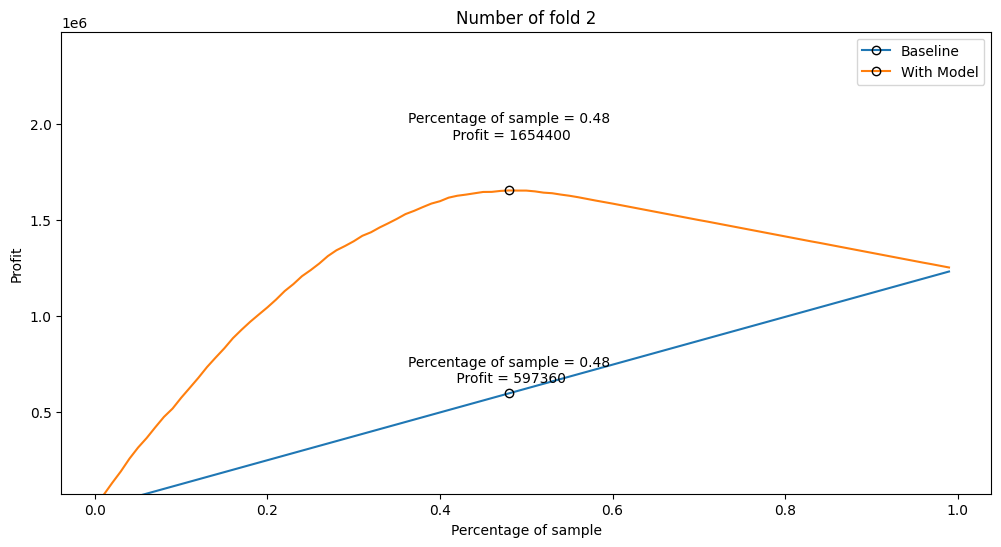

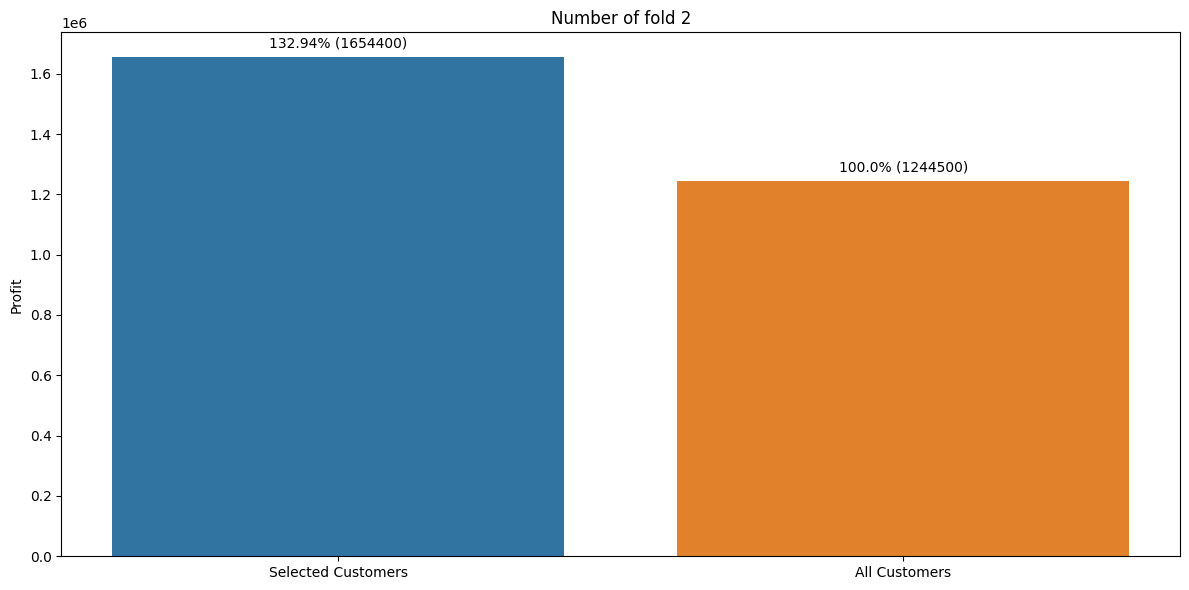

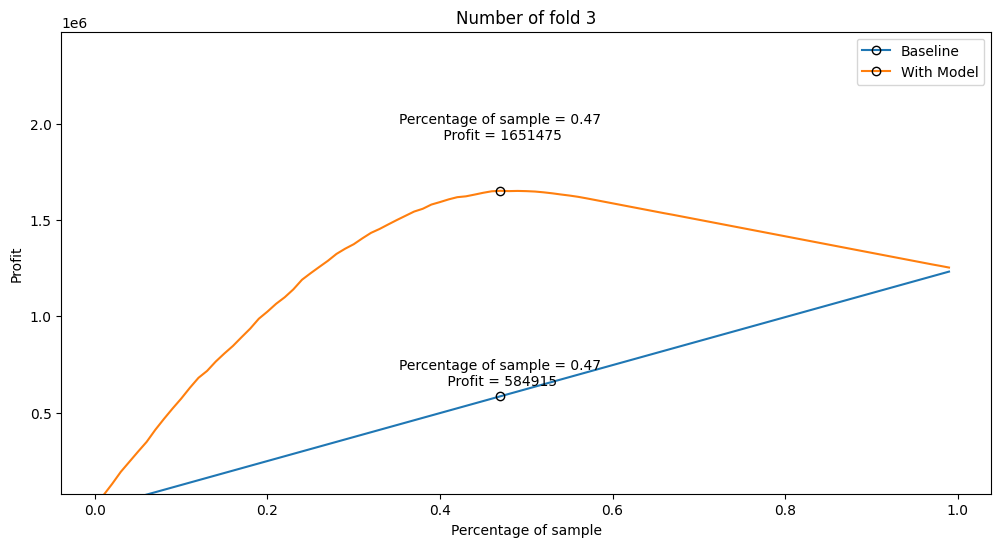

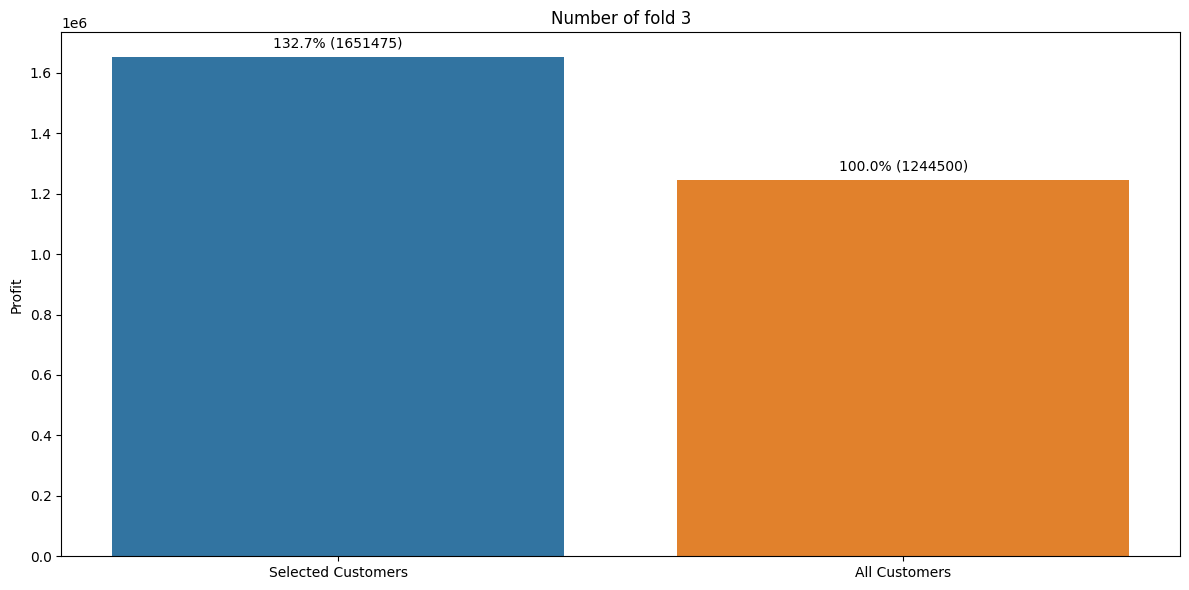

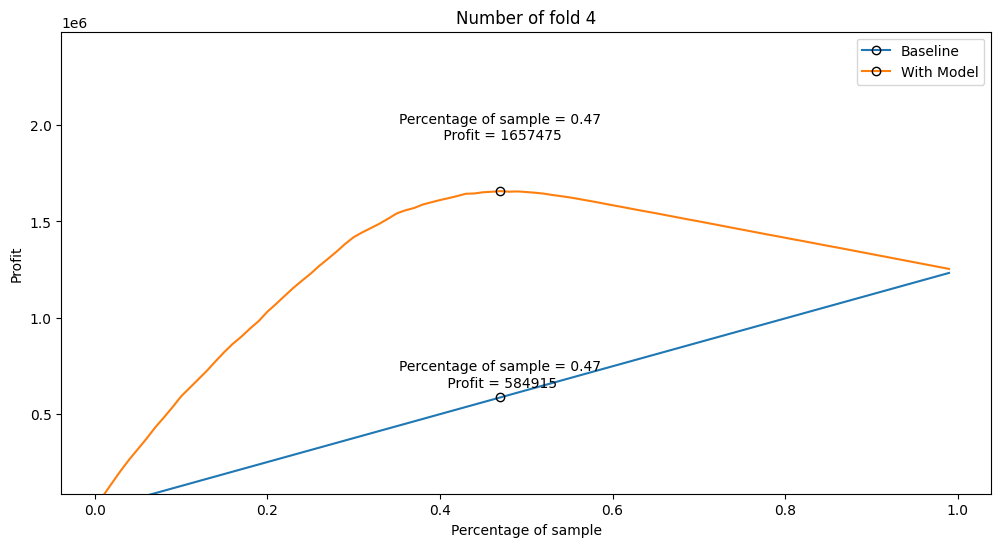

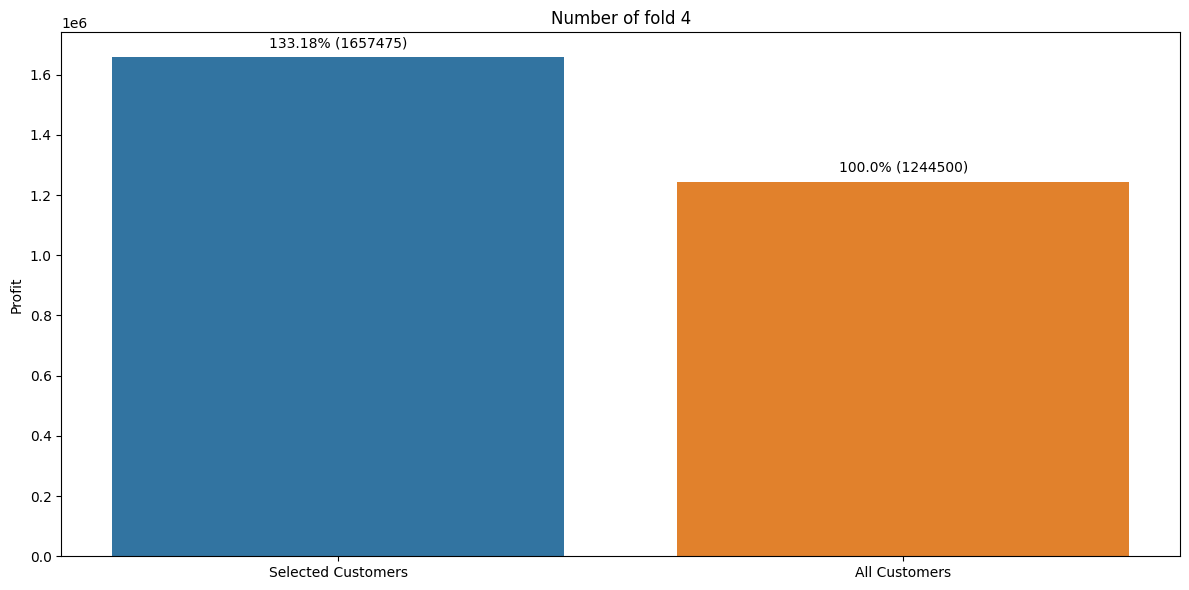

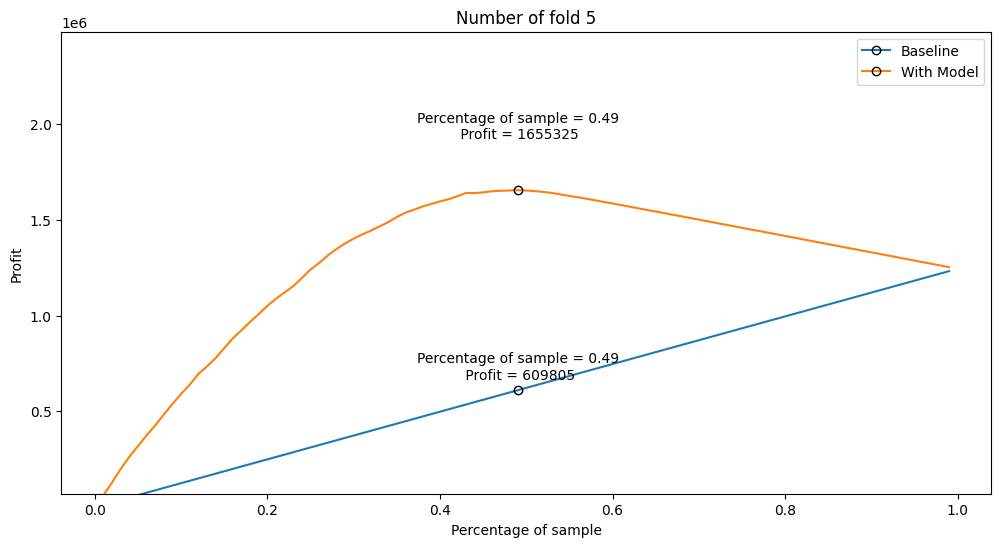

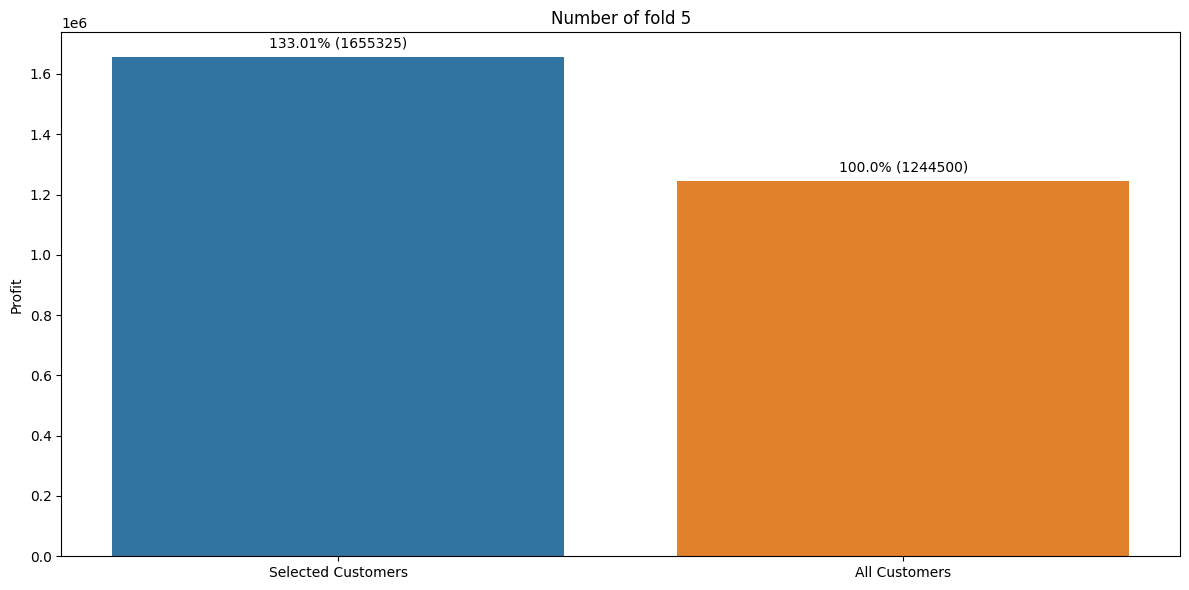

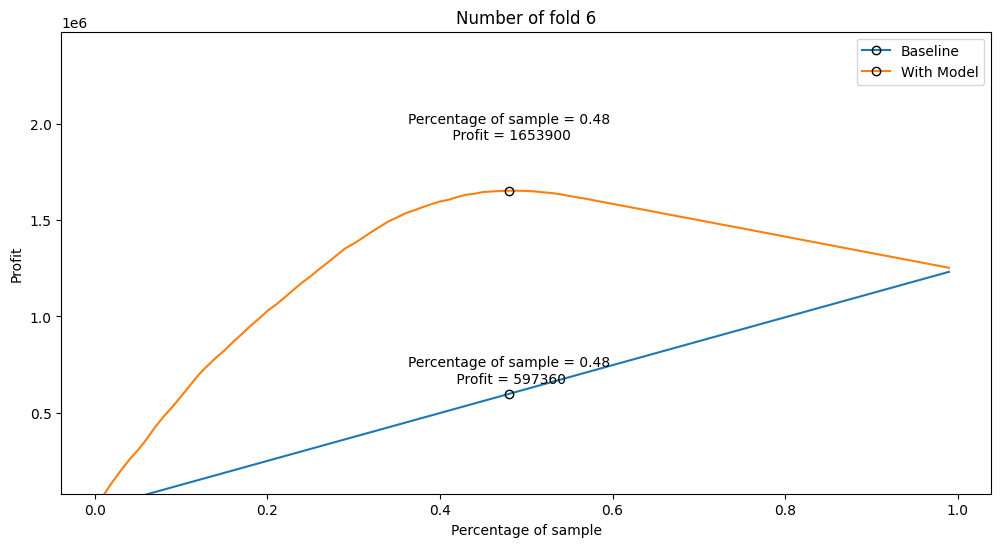

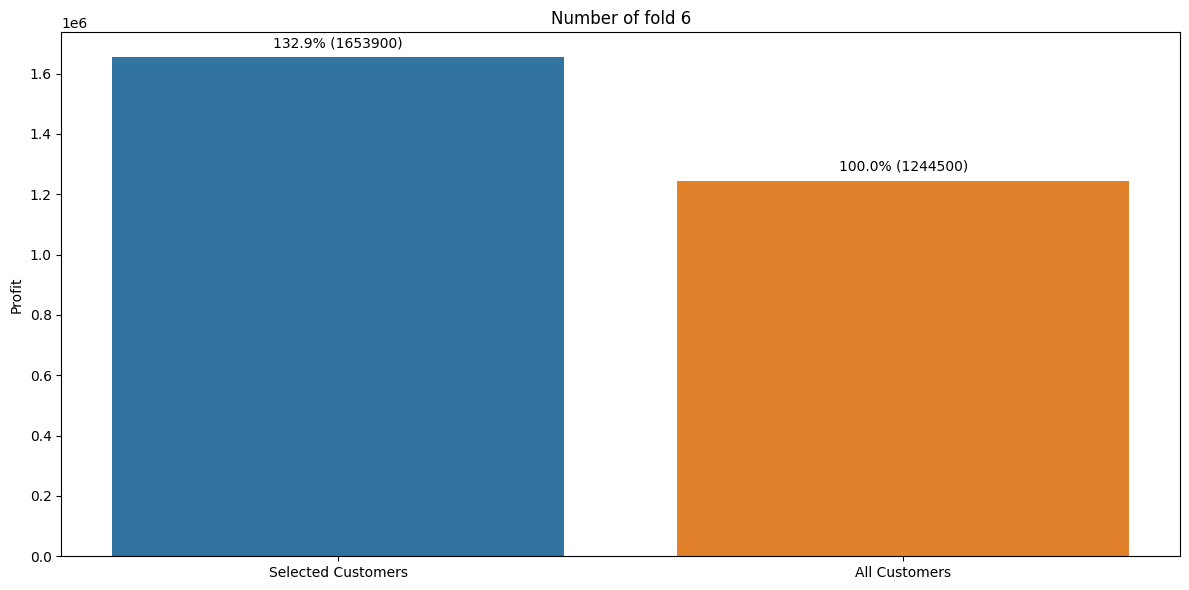

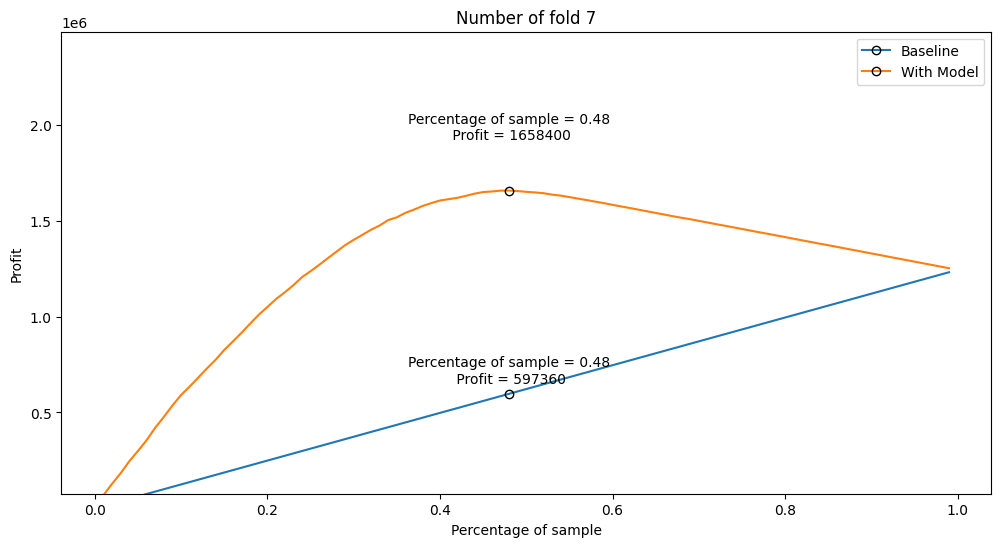

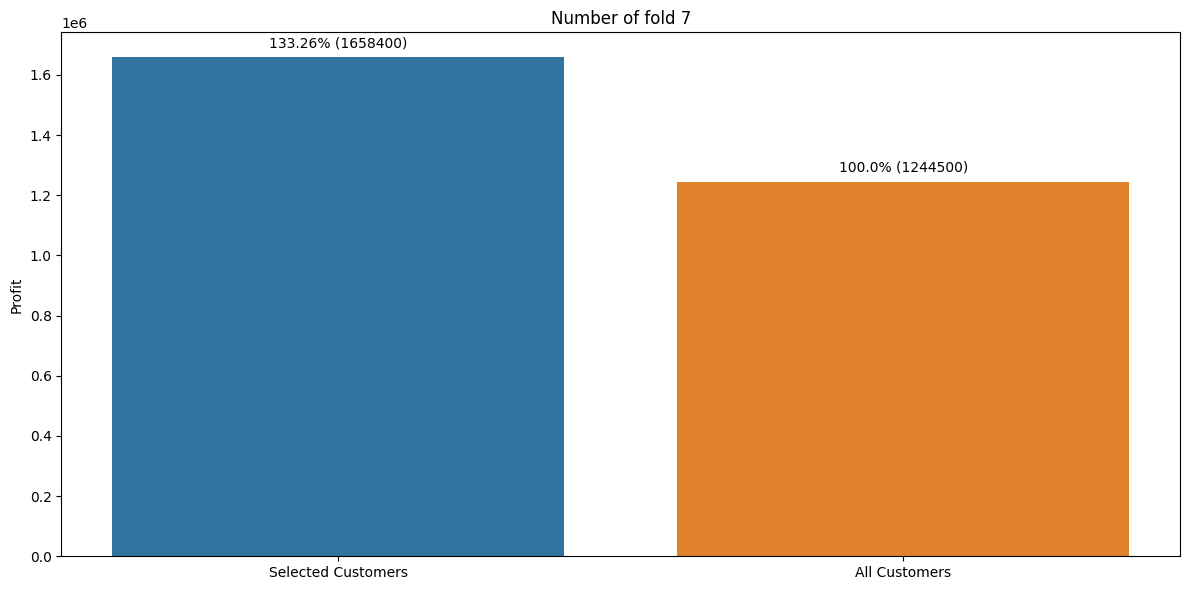

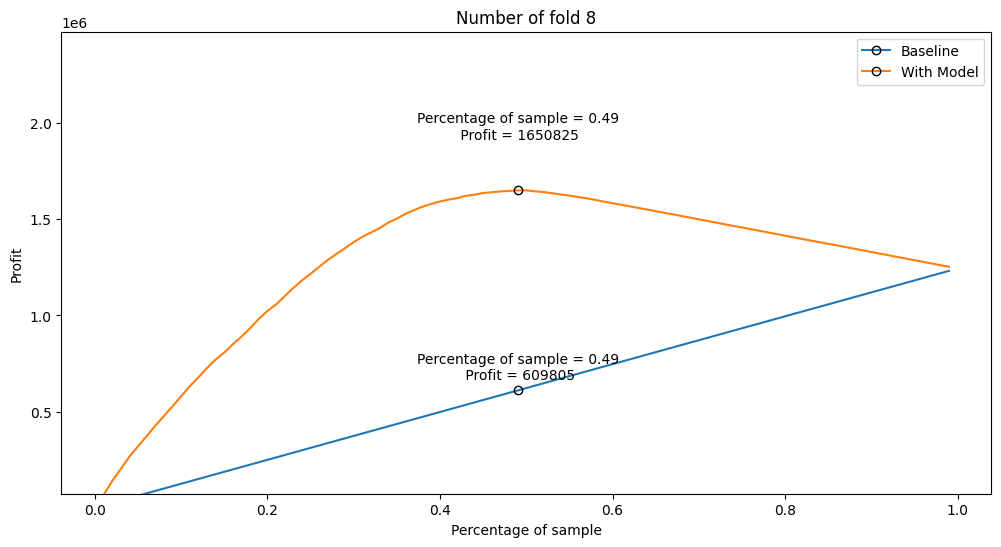

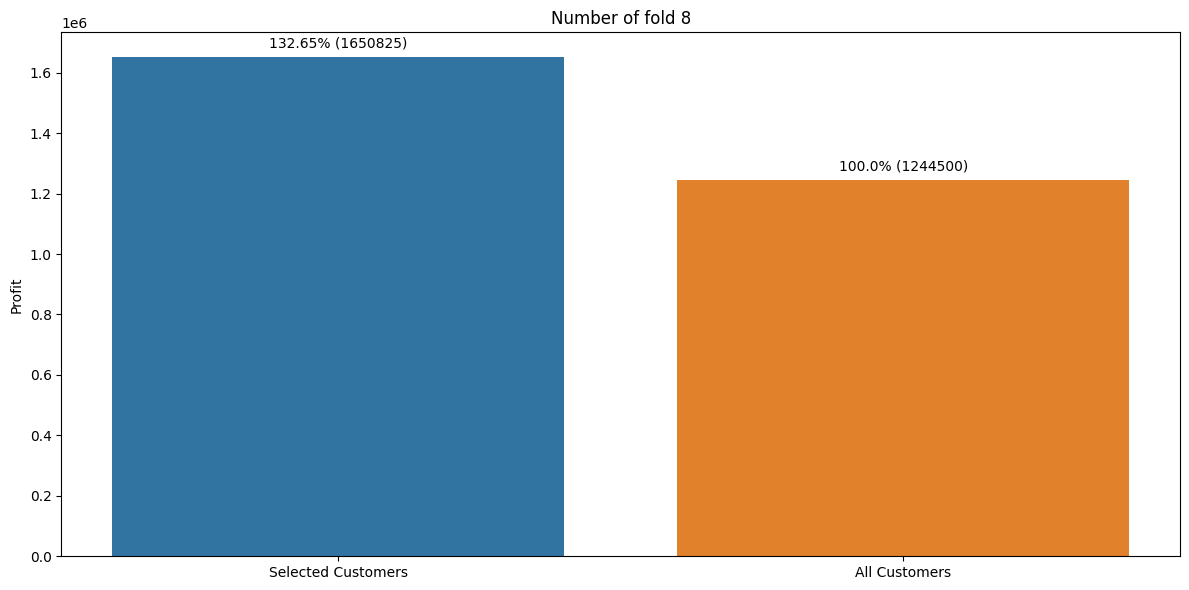

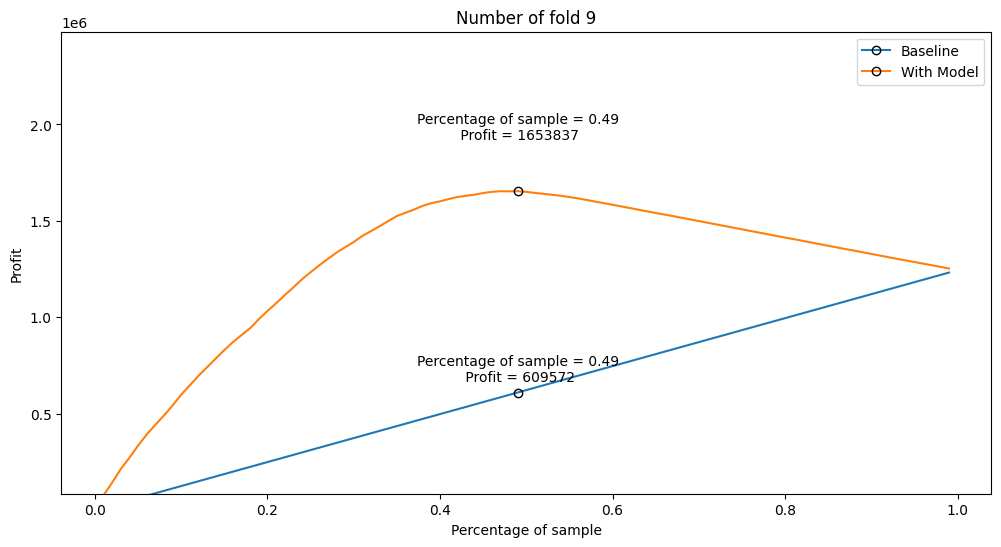

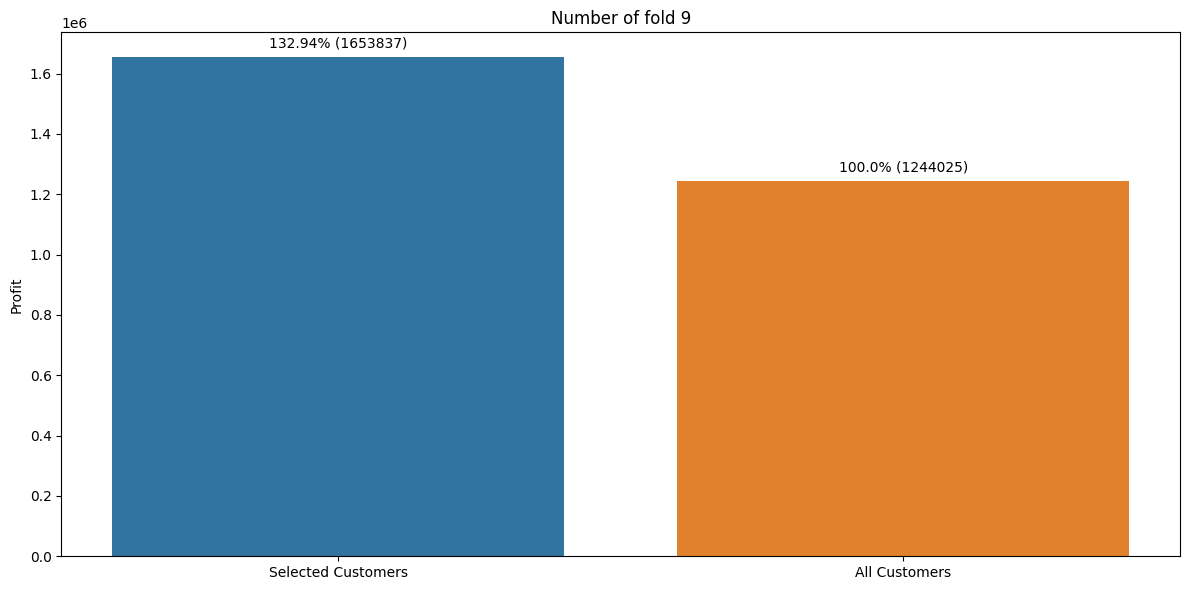

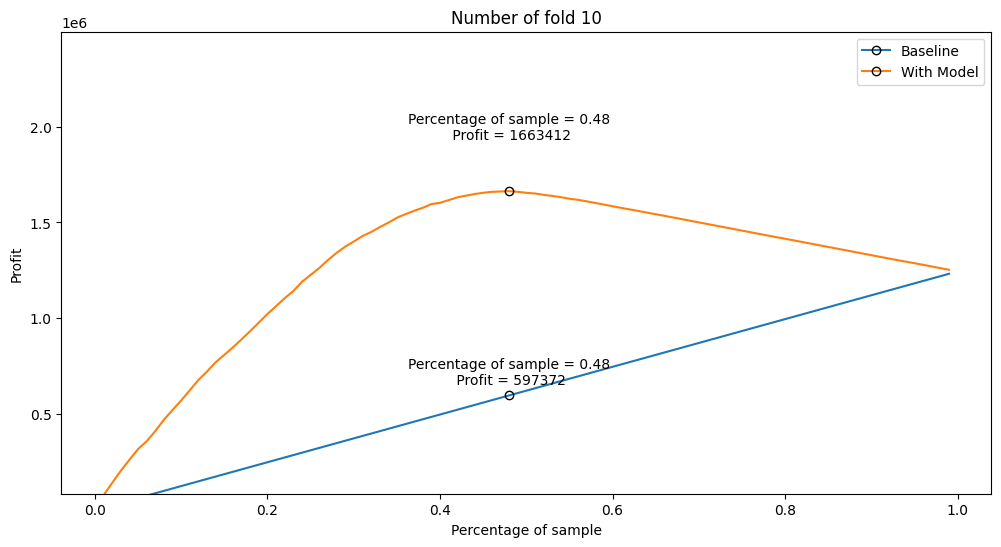

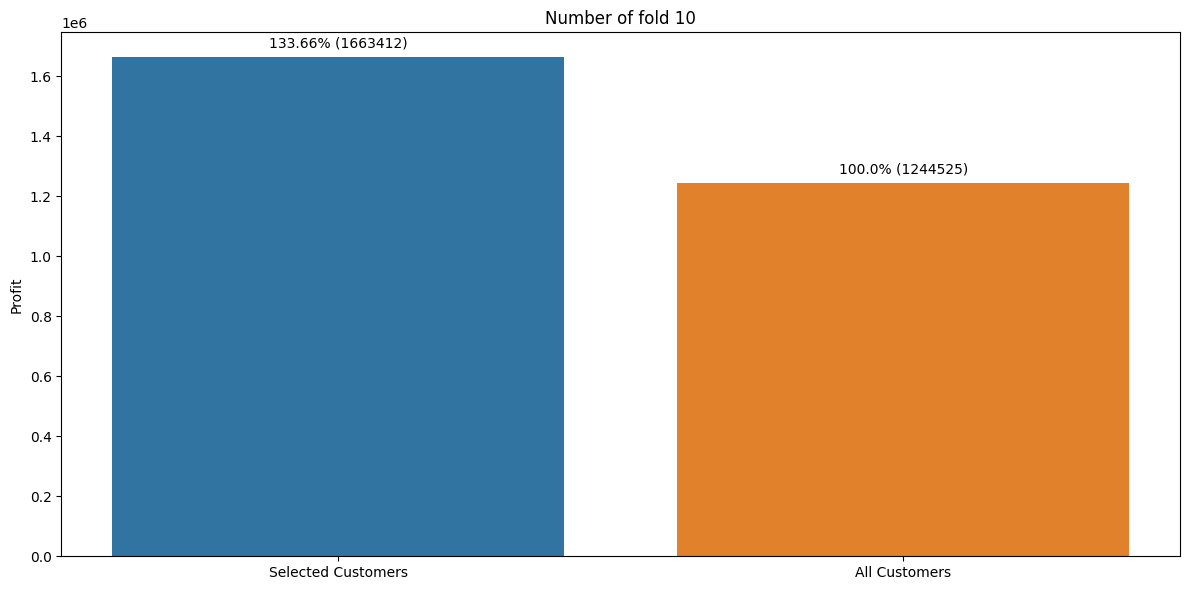

In [27]:
skf = StratifiedKFold(n_splits=10)

model = LGBMClassifier(learning_rate=0.00621, num_leaves=51, 
                         min_child_samples=67, subsample=0.938762, 
                         colsample_bytree=0.861679, random_state=0, subsample_freq=1,
                         n_estimators=1000, class_weight='balanced')


insurance_functions.profit_cross_validation( x_data=cv_x, y_data=cv_y,dataset=dataset, skf=skf, model=model, sample_size=0.4, insurance_price=insurance_price, deal_cost=deal_cost)

média dos pontos de corte: 47.66

std: 0.66

média do lucro: 133.08

std: 0.34

# Health Insurance Class

## Training the final model

In [30]:
data = pd.read_csv('data/saved_data/X_base.csv')

In [31]:
# Feature Engineering
# vehicle_age
data['vehicle_age'] = data['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year'
                                                                        if x == '1-2 Year' else 'below_1_year' )
# vehicle_damage
data['vehicle_damage'] = data['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

#########################################################################################################################
# Pre-Processing
# Standardization
ss = pp.StandardScaler()

# Annual Premium
data['annual_premium'] = ss.fit_transform( data[['annual_premium']].values )
pickle.dump( ss, open('src/features/annual_premium.pkl', 'wb') )

# Rescaling
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
data['age'] = mms_age.fit_transform( data[['age']].values )
pickle.dump( mms_age, open('src/features/age.pkl', 'wb') )

# Vintage
data['vintage'] = mms_vintage.fit_transform( data[['vintage']].values )
pickle.dump( mms_vintage, open('src/features/vintage.pkl', 'wb') )

# Encoder
# Gender
target_encode_gender = data.groupby( 'gender' )['response'].mean()
data.loc[:, 'gender'] = data['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open('src/features/gender.pkl', 'wb') )

# Region Code - Frequency Encoding / < Target Encoding > /  Weighted Target Encoding
target_encode_region_code = data.groupby( 'region_code' )['response'].mean()
data.loc[:, 'region_code'] = data['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open('src/features/region_code.pkl', 'wb') )


# Vehicle Age - < One Hot Encoding > / Order Enconding / Frequency Encoding
data = pd.get_dummies( data, prefix='vehicle_age', columns=['vehicle_age'] )

# Policy Sales Channel - Target Encoding / < Frequency Encoding >
fe_policy_sales_channel = data.groupby( 'policy_sales_channel' ).size() / len( data )
data.loc[:, 'policy_sales_channel'] = data['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open('src/features/policy_sales_channel.pkl', 'wb') )

#########################################################################################################################
# model training
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

X = data[cols_selected].copy()
y = data['response'].copy()

# model definition
lr_model = lm.LogisticRegression(penalty='elasticnet', C=0.01, class_weight='balanced', solver='saga', 
                                l1_ratio=0, random_state=0)

# model training
lr_model.fit( X, y )

pickle.dump( lr_model, open('src/models/lr_model.pkl', 'wb') )

# Health Insurance Class

In [33]:
class HealthInsurance( object ):
    
    def __init__(self):
        self.home_path = '/home/mars/repos/health_insurance'
        self.annual_premium_scaller = pickle.load( open( self.home_path + '/src/features/annual_premium.pkl', 'rb') )
        self.age_scaller =            pickle.load( open( self.home_path + '/src/features/age.pkl', 'rb') )
        self.vintage_scaller =        pickle.load( open( self.home_path + '/src/features/vintage.pkl', 'rb') )
        self.gender_scaller =         pickle.load( open( self.home_path + '/src/features/gender.pkl', 'rb') )
        self.region_code_scaller =    pickle.load( open( self.home_path + '/src/features/region_code.pkl', 'rb') )
        self.policy_sales_scaller =   pickle.load( open( self.home_path + '/src/features/policy_sales_channel.pkl', 'rb') )
        
#########################################################################################################################
    def feature_engineering( self, data):
        # vehicle_age
        data['vehicle_age'] = data['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year'
                                                                        if x == '1-2 Year' else 'below_1_year' )
        # vehicle_damage
        data['vehicle_damage'] = data['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )
        
        return( data )

#########################################################################################################################
    def pre_processing( self, data):
        # Standardization
        # Annual Premium
        data['annual_premium'] = self.annual_premium_scaller.transform( data[['annual_premium']].values )

        # Rescaling
        # Age
        data['age'] = self.age_scaller.transform( data[['age']].values )
        
        # Vintage
        data['vintage'] = self.vintage_scaller.transform( data[['vintage']].values )        

        # Encoder
        # Gender
        data.loc[:, 'gender'] = data['gender'].map( self.gender_scaller )

        # Region Code 
        data.loc[:, 'region_code'] = data['region_code'].map( self.region_code_scaller )
        
        # Vehicle Age
        data = pd.get_dummies( data, prefix='vehicle_age', columns=['vehicle_age'] )

        # Policy Sales Channel
        data.loc[:, 'policy_sales_channel'] = data['policy_sales_channel'].map( self.policy_sales_scaller )

        # Feature selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']
        
        return( data[ cols_selected ])

#########################################################################################################################
    def get_prediction( self, model, original_data, test_data):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )

# API Handler


In [35]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from src.HealthInsurance import HealthInsurance

# loading model
path = '/home/mars/repos/health_insurance/'
model = pickle.load( open( path + 'src/models/lr_model.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/predict', methods=['POST'] )
def health_insurance_predict():
    # Recebe um json
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.feature_engineering( test_raw )
        
        # feature engineering
        df2 = pipeline.pre_processing( df1 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df2 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.3.9:5000
Press CTRL+C to quit
 * Restarting with stat
Traceback (most recent call last):
  File "/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/traitlets/config/application.py", line 977, in launch_instance
    app.initialize(argv)
  File "/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/traitlets/config/application.py", line 110, in inner
    return method(app, *args, **kwargs)
  File "/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 666, in initialize
    self.init_sockets()
  File "/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 307, in init_sockets
    self.shell_por

SystemExit: 1

/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3386: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# API Tester

In [36]:
import requests
import json
import pandas as pd

In [37]:
# loading test dataset
df_test = pd.read_csv('/home/mars/repos/pa004_health_insurance_cross_sell/health__insurance_cross-sell/data/dataframe/test.csv')

In [38]:
df_test = df_test.sample(10)

In [39]:
# convert to json
data = json.dumps( df_test.to_dict( orient='records'))

In [40]:
data

'[{"id": 3796, "gender": "Male", "age": 28, "region_code": 12.0, "policy_sales_channel": 152.0, "driving_license": 1, "vehicle_age": "< 1 Year", "vehicle_damage": "No", "previously_insured": 1, "annual_premium": 29493.0, "vintage": 280, "response": 0}, {"id": 56219, "gender": "Male", "age": 47, "region_code": 8.0, "policy_sales_channel": 26.0, "driving_license": 1, "vehicle_age": "1-2 Year", "vehicle_damage": "Yes", "previously_insured": 1, "annual_premium": 40336.0, "vintage": 257, "response": 0}, {"id": 220339, "gender": "Male", "age": 33, "region_code": 15.0, "policy_sales_channel": 1.0, "driving_license": 1, "vehicle_age": "< 1 Year", "vehicle_damage": "Yes", "previously_insured": 1, "annual_premium": 2630.0, "vintage": 124, "response": 0}, {"id": 334483, "gender": "Male", "age": 53, "region_code": 11.0, "policy_sales_channel": 26.0, "driving_license": 1, "vehicle_age": "1-2 Year", "vehicle_damage": "Yes", "previously_insured": 0, "annual_premium": 33625.0, "vintage": 107, "respons

In [42]:
# API Call
# url = 'http://127.0.0.1:5000/predict'
url = 'https://health-insurance-api.onrender.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data  = data, headers=header )
print( f'Status Code {r.status_code}')

Status Code 200


In [43]:
d1 =  pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,score
5,115424,Male,54,8.0,124.0,1,1-2 Year,Yes,0,58507.0,61,0,0.686964
3,334483,Male,53,11.0,26.0,1,1-2 Year,Yes,0,33625.0,107,1,0.684740
9,34216,Male,40,14.0,26.0,1,1-2 Year,Yes,0,48298.0,58,0,0.677448
6,296506,Male,40,6.0,124.0,1,1-2 Year,Yes,0,32100.0,143,0,0.664384
2,220339,Male,33,15.0,1.0,1,< 1 Year,Yes,1,2630.0,124,0,0.061010
